In [1]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [2]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

,Factor Group,Field ID,Field Name,FactSet Screening Formula,Data Source,Unnamed: 6,Currency,Shares,CACCESS,Search Keywords,Data Type,String Length
0,Asset Data,DAYS_SINCE_RPT,Days Since Report,QFL_DAYS_SINCE_RPT(0),FactSet Estimates,"'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
1,Asset Data,DAYS_TO_RPT,Days to Report,QFL_DAYS_TO_RPT(0),FactSet Estimates,"'Days to Report': 'QFL_DAYS_TO_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
2,Asset Data,ADR_FLAG,ADR Flag,QFL_ADR_FLAG(0),FactSet Reference Data,"'ADR Flag': 'QFL_ADR_FLAG(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
3,Asset Data,BANKRUPTCY,Bankruptcy Flag,QFL_BANKRUPTCY(0),FactSet Reference Data,"'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
4,Asset Data,PRIMARY_LIST,Primary Listing,QFL_PRIMARY_LIST(0),FactSet Reference Data,"'Primary Listing': 'QFL_PRIMARY_LIST(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN


In [3]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [4]:
qfl_factors = globals()['qfl_{0}'.format('Liquidity').lower()] # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [5]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [6]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [7]:
qfl_df = df

In [8]:
qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_ADT(0,21D)","QFL_ADT(0,63D)","QFL_ADT(0,252D)","QFL_MDT(0,21D)","QFL_MDT(0,63D)","QFL_MDT(0,252D)","QFL_SHARETURN(0,21D)","QFL_SHARETURN(0,63D)","QFL_SHARETURN(0,252D)","QFL_ATVR(0,21D)","QFL_ATVR(0,63D)","QFL_ATVR(0,252D)","QFL_MTVR(0,21D)","QFL_MTVR(0,63D)","QFL_MTVR(0,252D)","QFL_BID_ASK_SPREAD(0,CT)","QFL_LIX(0,CT)"
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,1.181484e+10,1.569141e+10,1.388534e+10,1.234932e+10,1.471122e+10,1.230787e+10,-2.080314,-0.688320,0.814315,0.594719,0.797040,0.895446,0.633018,0.743375,0.807127,0.000168,9.685576
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,5.856479e+09,6.415240e+09,6.744251e+09,5.607475e+09,6.080198e+09,6.266410e+09,-2.578978,-1.374287,0.193359,0.361197,0.401605,0.481389,0.339707,0.382804,0.431323,0.000514,9.256083
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,1.359348e+10,1.590253e+10,1.242199e+10,1.287131e+10,1.552212e+10,1.200944e+10,-1.709095,-0.462338,0.887554,0.862046,0.999777,0.963983,0.809947,0.977481,0.904469,0.000410,8.097574
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,4.696653e+09,5.437972e+09,4.964228e+09,4.141899e+09,4.988965e+09,4.519198e+09,-1.907693,-0.639376,0.824581,0.706773,0.837489,0.905135,0.625645,0.780410,0.824529,0.000036,8.839550
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,2.911063e+09,2.809199e+09,2.614808e+09,2.740834e+09,2.522067e+09,2.422895e+09,-2.242193,-1.099692,0.318690,0.505835,0.528545,0.545585,0.478891,0.485134,0.493905,0.000670,7.987313


In [9]:
qfl_df.tail()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_ADT(0,21D)","QFL_ADT(0,63D)","QFL_ADT(0,252D)","QFL_MDT(0,21D)","QFL_MDT(0,63D)","QFL_MDT(0,252D)","QFL_SHARETURN(0,21D)","QFL_SHARETURN(0,63D)","QFL_SHARETURN(0,252D)","QFL_ATVR(0,21D)","QFL_ATVR(0,63D)","QFL_ATVR(0,252D)","QFL_MTVR(0,21D)","QFL_MTVR(0,63D)","QFL_MTVR(0,252D)","QFL_BID_ASK_SPREAD(0,CT)","QFL_LIX(0,CT)"
1595,890100,30-Nov-2020,BZ22BK,0.002738,SmartCentres Real Estate Investment Trust,Real Estate,Canada,-3.552645,Mid Cap,2688.3582,17156056.0,11591682.0,10703763.0,12783134.0,9767437.0,8594413.0,-2.004782,-1.222668,0.068459,0.641379,0.467370,0.424779,0.475135,0.370770,0.352842,0.007057,8.362404
1596,890100,30-Nov-2020,B2NT8S,0.002637,"Seven Bank, Ltd.",Financials,Japan,-4.803491,Mid Cap,2619.2988,19940340.0,11884663.0,10951249.0,16721982.0,9307329.0,9997350.0,-1.856060,-1.309878,-0.134559,0.744225,0.428338,0.346864,0.619244,0.313989,0.303797,0.004329,8.735026
1597,890100,30-Nov-2020,BKSLS5,0.002617,First Capital Real Estate Investment Trust,Real Estate,Canada,-12.513375,Mid Cap,2634.8494,15714347.0,10565614.0,12107526.0,9779766.0,7595734.5,8311638.5,-2.040148,-1.274724,0.123427,0.618764,0.443330,0.448911,0.393061,0.338360,0.330066,0.007707,8.407961
1598,890100,30-Nov-2020,659844,0.002463,Mitsubishi Motors Corporation,Consumer Discretionary,Japan,15.425528,Mid Cap,2808.4746,33948476.0,21659870.0,22007988.0,29786888.0,17280876.0,20771754.0,-1.374909,-0.794597,0.333574,1.204107,0.717084,0.553948,1.085177,0.564531,0.496936,0.010204,8.804896
1599,890100,30-Nov-2020,656950,0.002419,Maruichi Steel Tube Ltd.,Materials,Japan,4.007292,Small Cap,2063.3816,17608676.0,11420798.0,7055702.0,10847695.0,9268978.0,5820449.5,-1.735586,-1.132992,-0.277832,0.839509,0.511219,0.300565,0.499468,0.388723,0.239149,0.002190,7.555417


In [10]:
# Summary Stats

qfl_df.describe()

,BENCHMARK_ID,Weight,p_total_return,qfl_mkt_val_sec,"QFL_ADT(0,21D)","QFL_ADT(0,63D)","QFL_ADT(0,252D)","QFL_MDT(0,21D)","QFL_MDT(0,63D)","QFL_MDT(0,252D)","QFL_SHARETURN(0,21D)","QFL_SHARETURN(0,63D)","QFL_SHARETURN(0,252D)","QFL_ATVR(0,21D)","QFL_ATVR(0,63D)","QFL_ATVR(0,252D)","QFL_MTVR(0,21D)","QFL_MTVR(0,63D)","QFL_MTVR(0,252D)","QFL_BID_ASK_SPREAD(0,CT)","QFL_LIX(0,CT)"
count,1600.0,1600.000000,1597.000000,1.598000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1598.000000,1592.000000,1592.000000,1598.000000,1596.000000,1592.000000,1598.000000,1596.000000,1592.000000,1598.000000,1598.000000
mean,890100.0,0.062500,3.118575,3.489420e+04,1.980517e+08,1.902867e+08,1.854464e+08,1.802431e+08,1.707740e+08,1.630064e+08,-2.369023,-1.382347,0.125187,0.587142,0.533805,0.606464,0.525967,0.473107,0.522261,0.003421,7.929798
std,0.0,0.177252,7.256757,9.150908e+04,7.356773e+08,8.685138e+08,7.207177e+08,6.641356e+08,7.953313e+08,6.286572e+08,0.714896,0.732661,0.731278,0.593510,0.580295,0.686601,0.504466,0.486516,0.579067,0.011795,0.638220
min,890100.0,0.002419,-31.602722,2.063382e+03,3.022633e+06,2.589317e+06,2.509644e+06,2.133428e+06,1.947676e+06,2.089820e+06,-5.122542,-4.237446,-2.662665,0.028385,0.022928,0.027683,0.025460,0.021014,0.022597,0.000000,3.910180
25%,890100.0,0.012927,-1.169592,8.494103e+03,3.051190e+07,2.489109e+07,2.700947e+07,2.693004e+07,2.210182e+07,2.394549e+07,-2.790799,-1.837255,-0.352484,0.292249,0.253116,0.278566,0.264910,0.226065,0.238819,0.000485,7.537340
50%,890100.0,0.024960,2.384615,1.491753e+04,7.062235e+07,6.154592e+07,6.650007e+07,6.563388e+07,5.528929e+07,5.652286e+07,-2.402747,-1.407242,0.108352,0.430841,0.391199,0.442272,0.395636,0.354575,0.378872,0.001186,7.945344
75%,890100.0,0.057592,6.821418,3.202311e+04,1.641491e+08,1.456829e+08,1.525015e+08,1.539666e+08,1.333077e+08,1.363612e+08,-1.956609,-0.923602,0.592626,0.673030,0.630953,0.717858,0.626617,0.568712,0.627092,0.003147,8.338384
max,890100.0,4.204100,53.399338,2.024064e+06,1.797330e+10,2.167491e+10,1.666345e+10,1.445052e+10,1.902722e+10,1.315410e+10,0.639911,1.819141,3.242628,9.097599,9.909861,10.288166,7.761982,7.456094,9.113453,0.375000,10.025116


In [11]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID                0
DATE                        0
SECURITY_ID                 0
Weight                      0
proper_name                 0
fg_gics_sector              2
proper                      0
p_total_return              3
qfl_size_class              2
qfl_mkt_val_sec             2
QFL_ADT(0,21D)              2
QFL_ADT(0,63D)              4
QFL_ADT(0,252D)             8
QFL_MDT(0,21D)              2
QFL_MDT(0,63D)              4
QFL_MDT(0,252D)             8
QFL_SHARETURN(0,21D)        2
QFL_SHARETURN(0,63D)        8
QFL_SHARETURN(0,252D)       8
QFL_ATVR(0,21D)             2
QFL_ATVR(0,63D)             4
QFL_ATVR(0,252D)            8
QFL_MTVR(0,21D)             2
QFL_MTVR(0,63D)             4
QFL_MTVR(0,252D)            8
QFL_BID_ASK_SPREAD(0,CT)    2
QFL_LIX(0,CT)               2
dtype: int64

In [12]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if idx > 9 and qfl_df[col].values.dtype == 'float64']

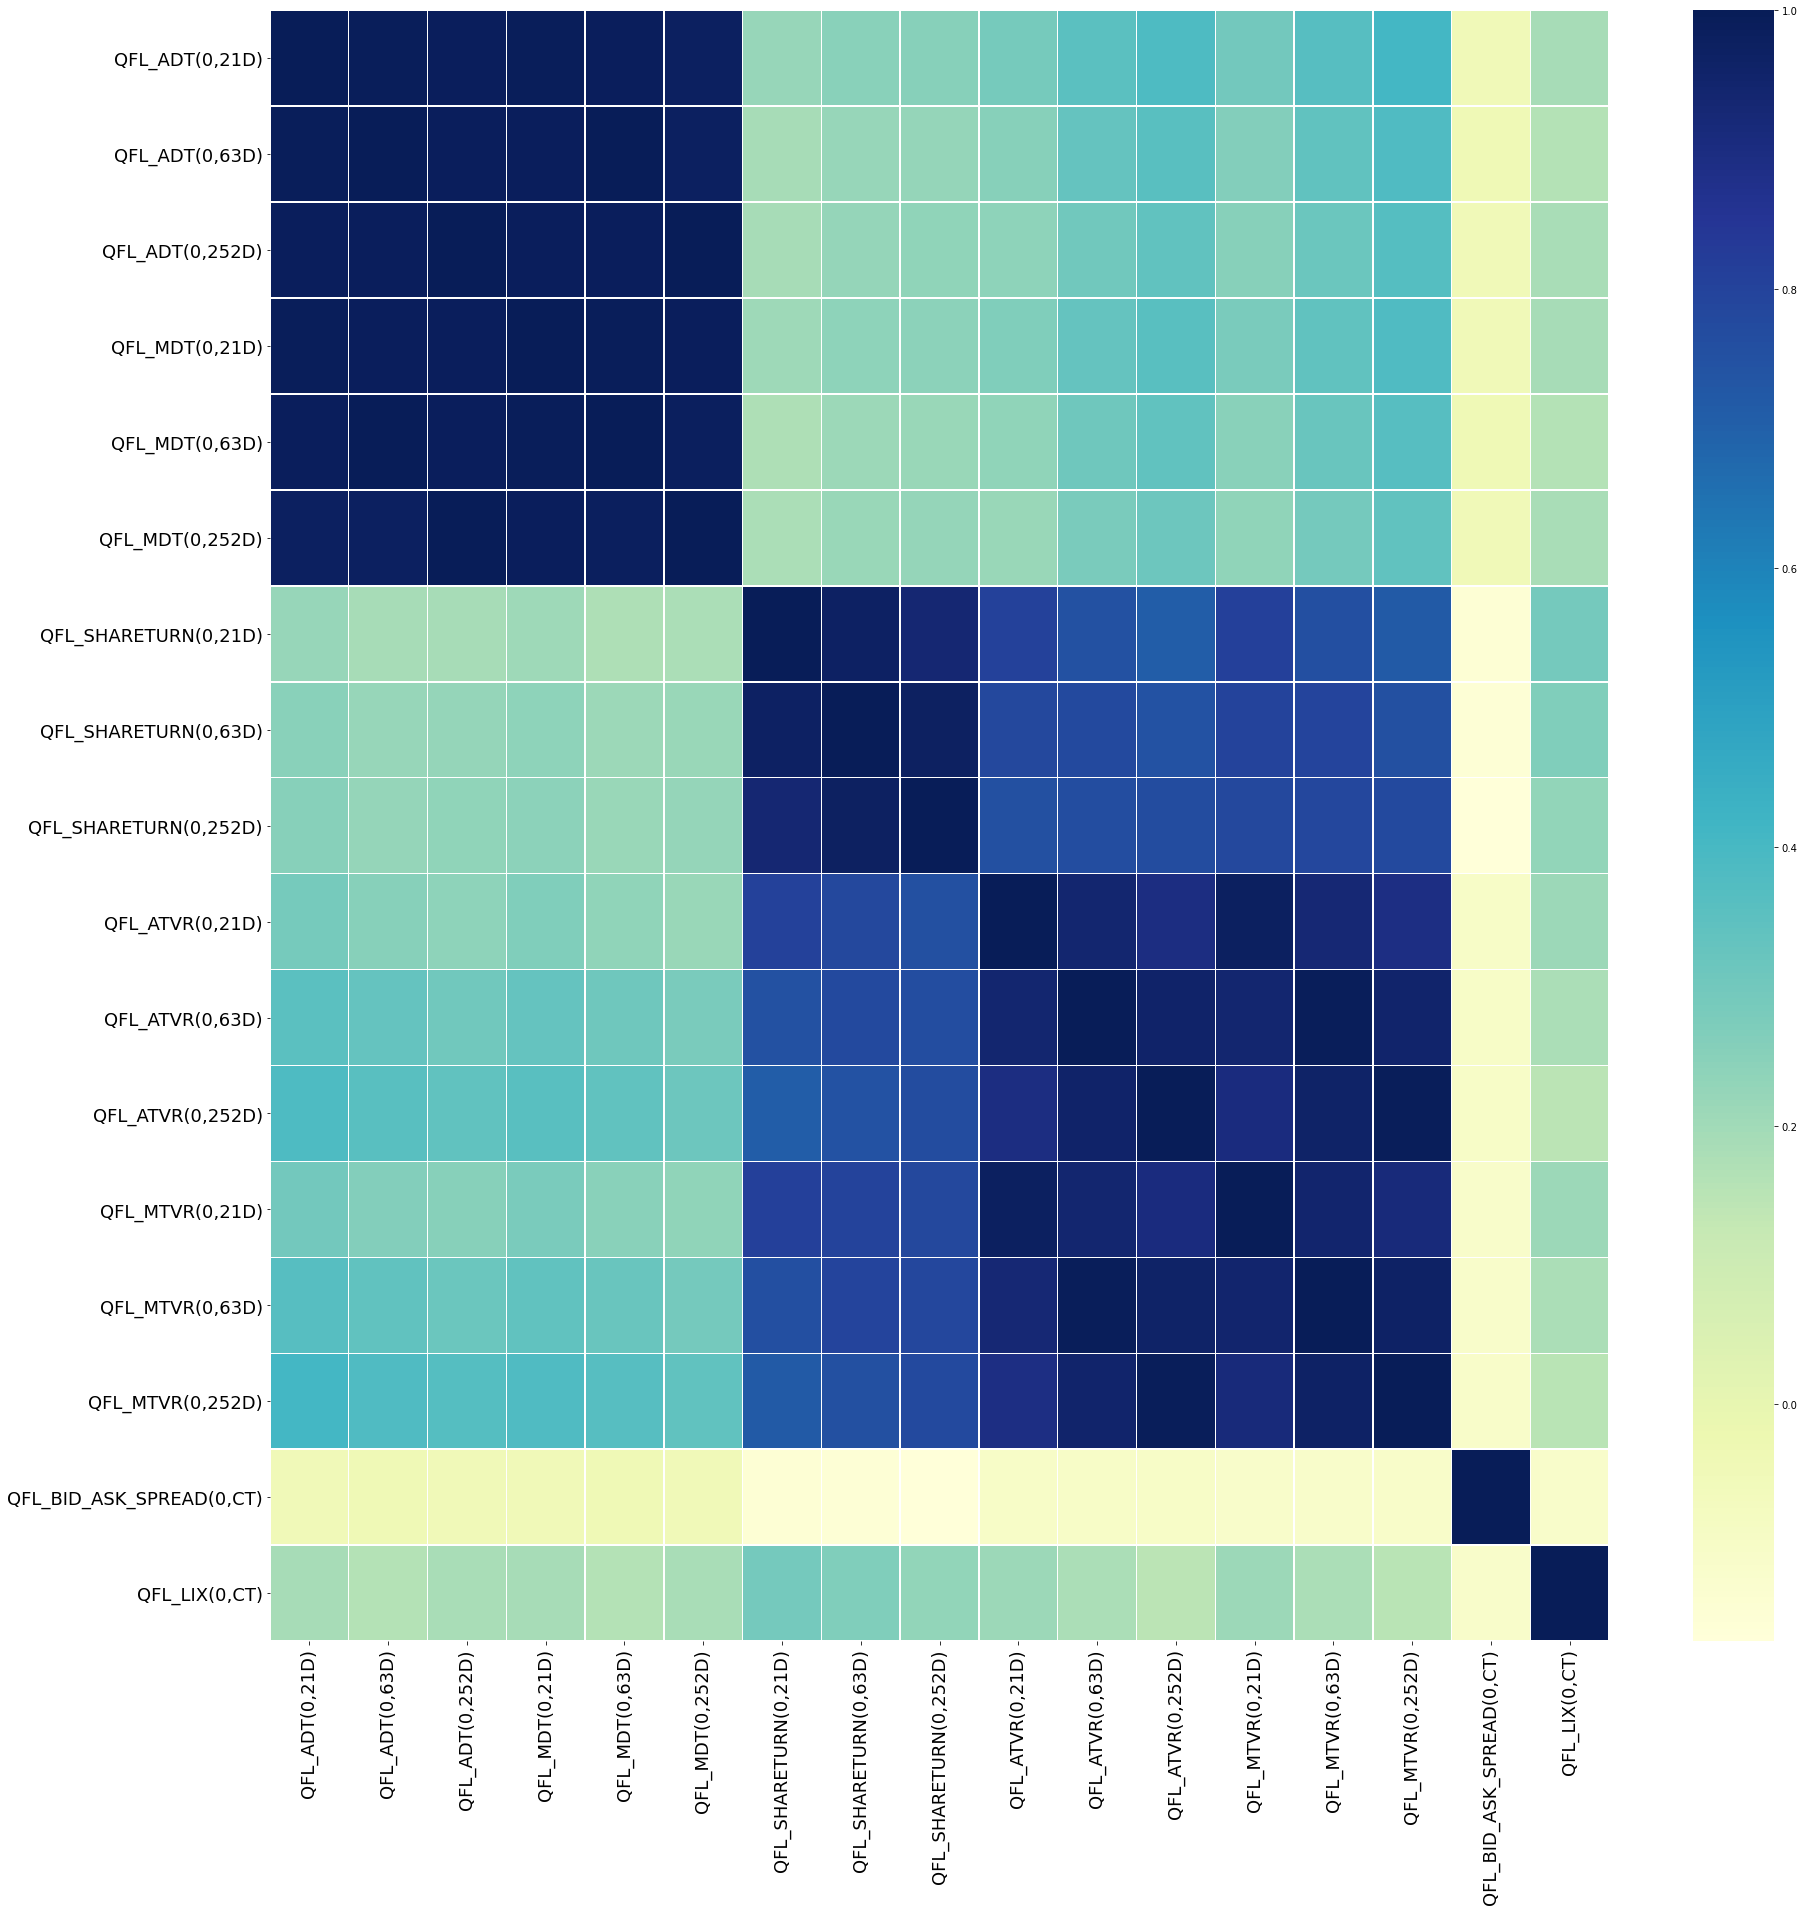

In [50]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

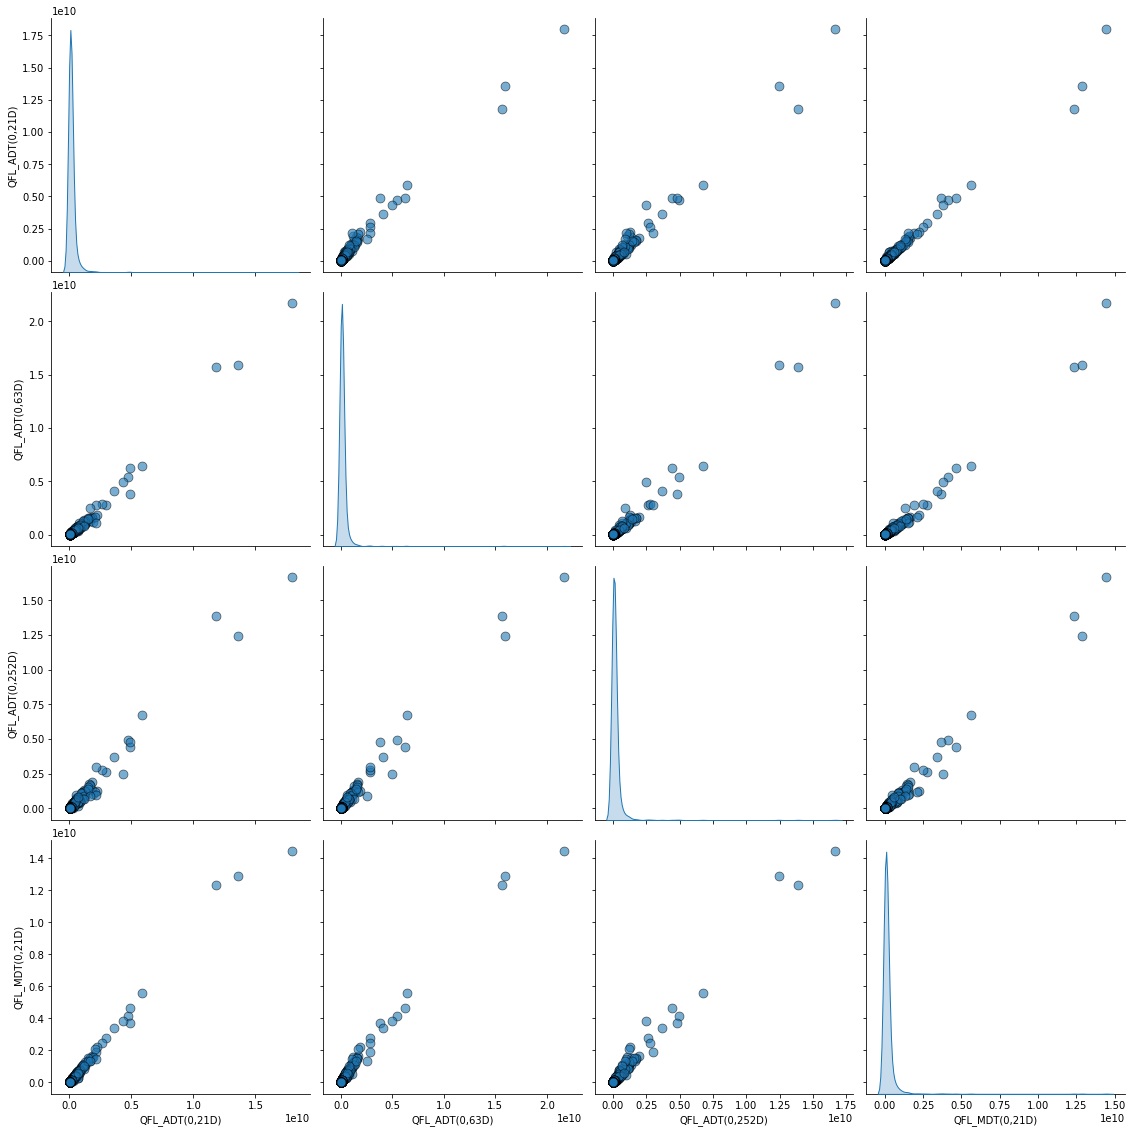

In [14]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [15]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

,"QFL_ADT(0,21D)","QFL_ADT(0,63D)","QFL_ADT(0,252D)","QFL_MDT(0,21D)"
0,1.181484e+10,1.569141e+10,1.388534e+10,1.234932e+10
1,5.856479e+09,6.415240e+09,6.744251e+09,5.607475e+09
2,1.359348e+10,1.590253e+10,1.242199e+10,1.287131e+10
3,4.696653e+09,5.437972e+09,4.964228e+09,4.141899e+09
4,2.911063e+09,2.809199e+09,2.614808e+09,2.740834e+09
...,...,...,...,...
1595,1.715606e+07,1.159168e+07,1.070376e+07,1.278313e+07
1596,1.994034e+07,1.188466e+07,1.095125e+07,1.672198e+07
1597,1.571435e+07,1.056561e+07,1.210753e+07,9.779766e+06
1598,3.394848e+07,2.165987e+07,2.200799e+07,2.978689e+07


In [16]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

,nobs,minmax,mean,variance,skewness,kurtosis
"QFL_ADT(0,21D)",1598,"[3022632.8, 17973295000.0]",1.98052e+08,5.41221e+17,16.18,324.85
"QFL_ADT(0,63D)",1596,"[2589317.0, 21674914000.0]",1.90287e+08,7.54316e+17,17.66,368.01
"QFL_ADT(0,252D)",1592,"[2509643.5, 16663450000.0]",1.85446e+08,5.19434e+17,16.12,311.47
"QFL_MDT(0,21D)",1598,"[2133428.3, 14450523000.0]",1.80243e+08,4.41076e+17,15.55,291.46
"QFL_MDT(0,63D)",1596,"[1947676.1, 19027218000.0]",1.70774e+08,6.32552e+17,17.57,357.53
"QFL_MDT(0,252D)",1592,"[2089819.6, 13154099000.0]",1.63006e+08,3.9521e+17,15.63,288.29
"QFL_SHARETURN(0,21D)",1598,"[-5.12, 0.64]",-2.37,0.51,0.13,1.12
"QFL_SHARETURN(0,63D)",1592,"[-4.24, 1.82]",-1.38,0.54,0.14,1.04
"QFL_SHARETURN(0,252D)",1592,"[-2.66, 3.24]",0.13,0.53,0.2,1.07
"QFL_ATVR(0,21D)",1598,"[0.03, 9.1]",0.59,0.35,5.21,45.18


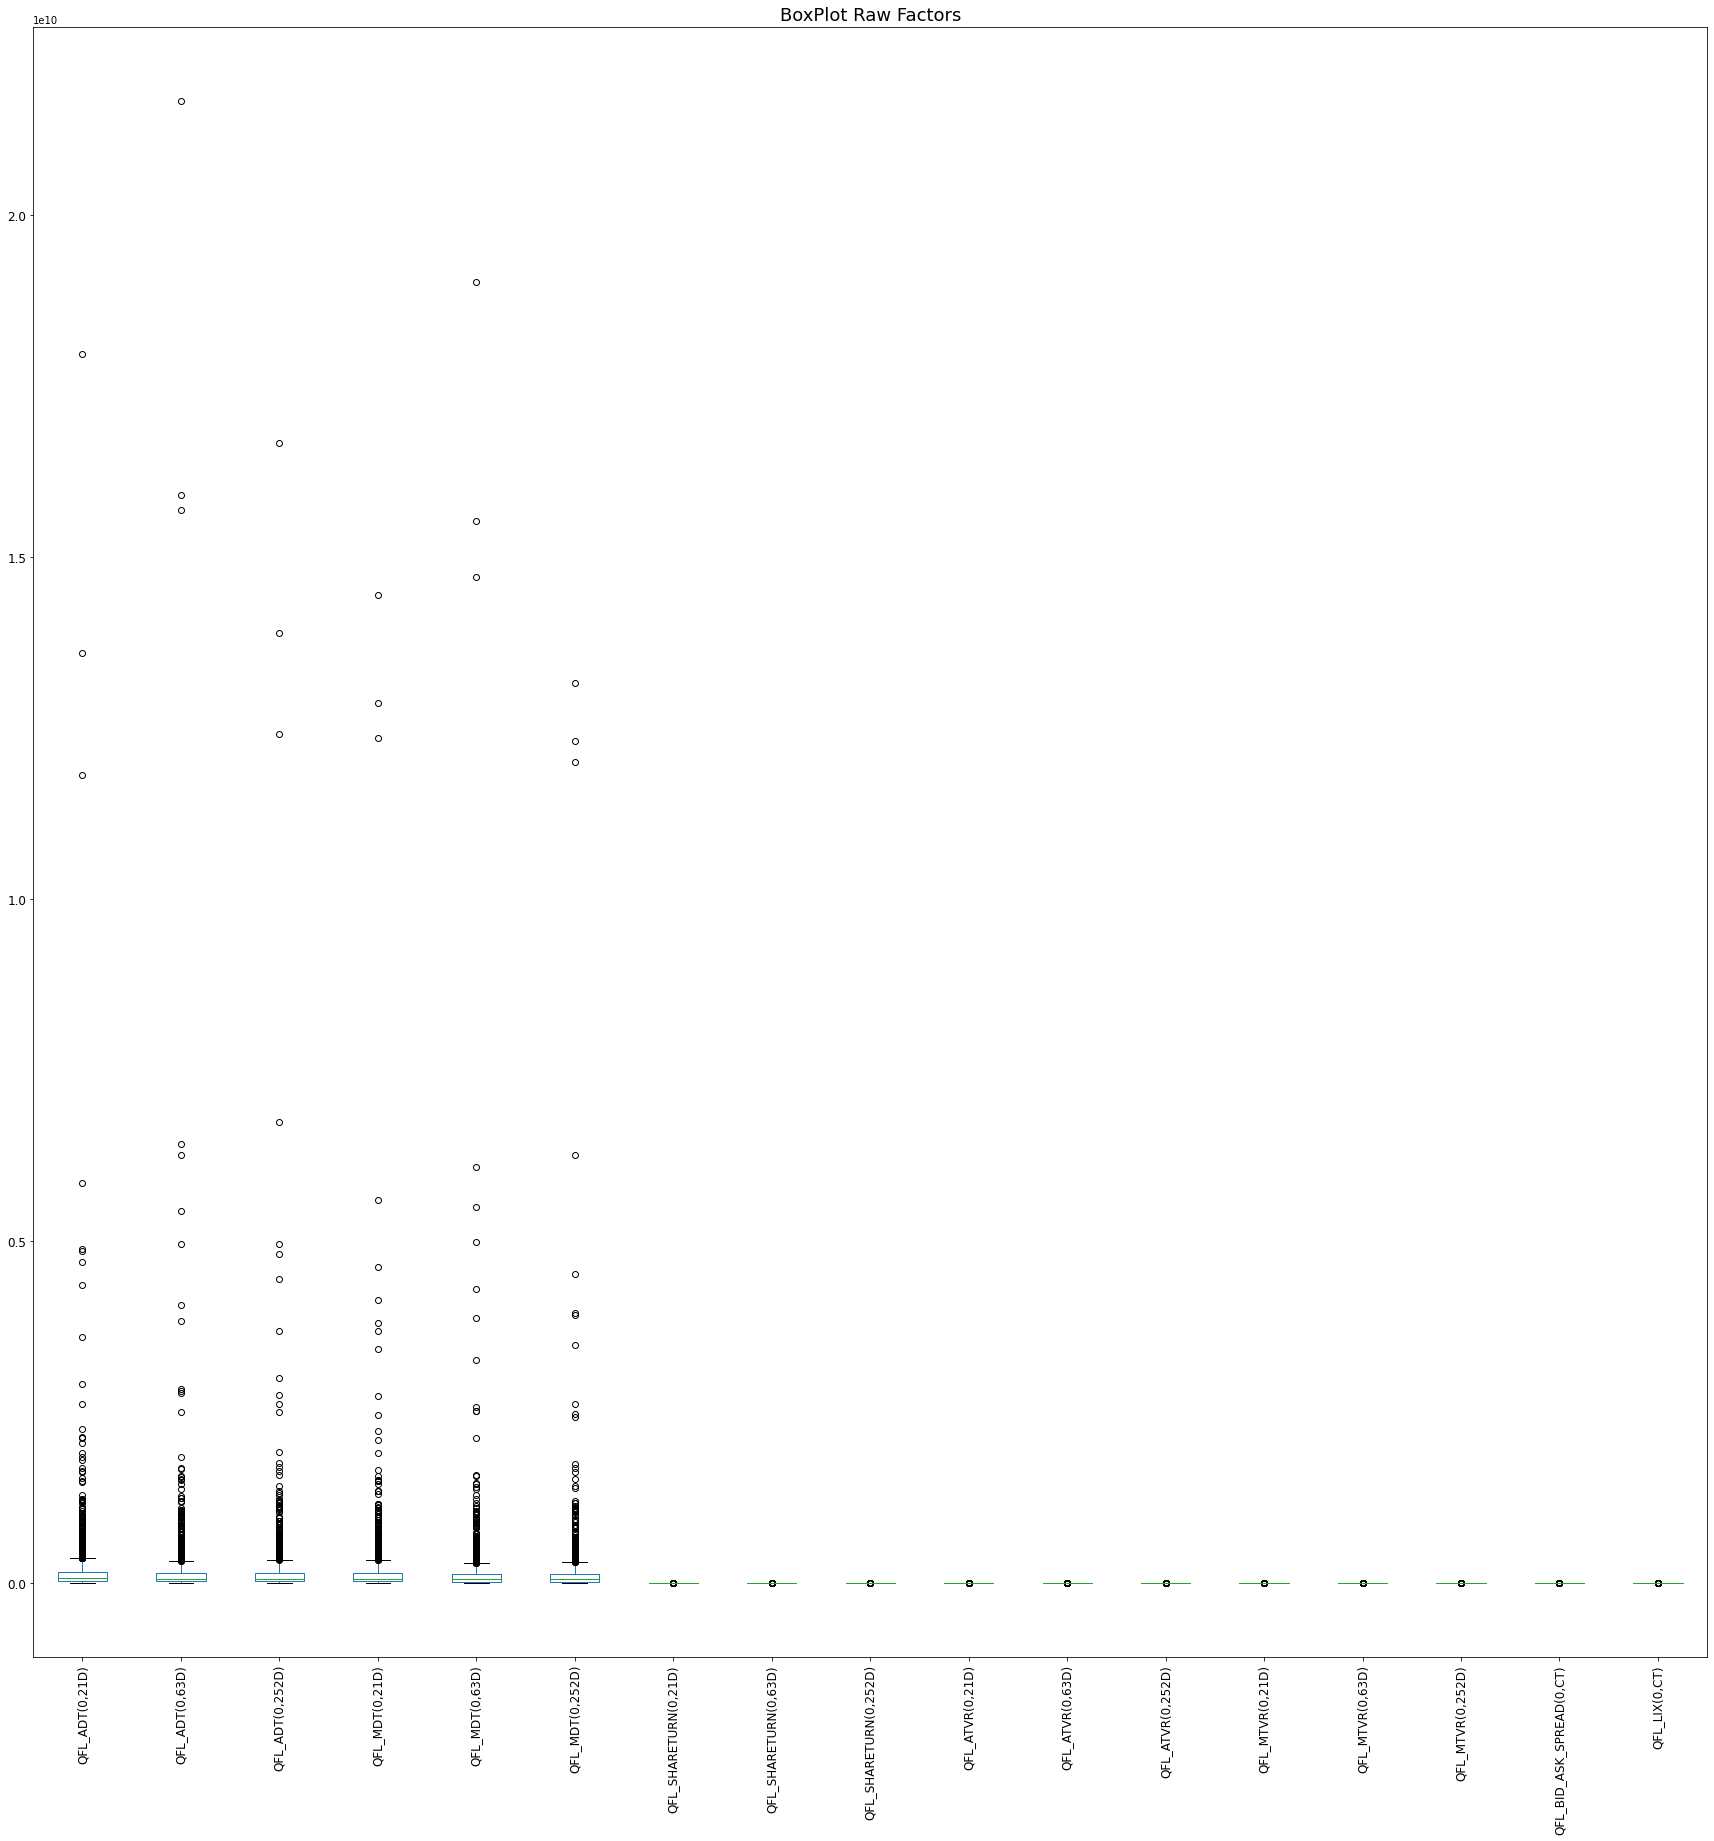

In [17]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [18]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

,"QFL_ADT(0,21D)","QFL_ADT(0,63D)","QFL_ADT(0,252D)","QFL_MDT(0,21D)","QFL_MDT(0,63D)","QFL_MDT(0,252D)","QFL_SHARETURN(0,21D)","QFL_SHARETURN(0,63D)","QFL_SHARETURN(0,252D)","QFL_ATVR(0,21D)","QFL_ATVR(0,63D)","QFL_ATVR(0,252D)","QFL_MTVR(0,21D)","QFL_MTVR(0,63D)","QFL_MTVR(0,252D)","QFL_BID_ASK_SPREAD(0,CT)","QFL_LIX(0,CT)"
count,1.598000e+03,1.596000e+03,1.592000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.598000e+03,1.592000e+03,1.592000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.598000e+03,1.598000e+03
mean,3.194149e-17,-1.164308e-16,-2.540193e-16,-9.077011e-17,2.720951e-16,2.015417e-16,-1.594330e-15,-1.689394e-16,-4.887213e-16,6.410531e-16,7.224102e-17,2.550828e-15,2.005601e-15,2.392997e-15,-1.042054e-15,-1.922655e-16,-1.102928e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.651014e-01,-2.161133e-01,-2.538258e-01,-2.681827e-01,-2.122717e-01,-2.559687e-01,-3.851635e+00,-3.896888e+00,-3.812302e+00,-9.414443e-01,-8.803759e-01,-8.429655e-01,-9.921519e-01,-9.292464e-01,-8.628764e-01,-2.900430e-01,-6.298168e+00
25%,-2.277355e-01,-1.904352e-01,-2.198321e-01,-2.308460e-01,-1.869312e-01,-2.212030e-01,-5.899813e-01,-6.208985e-01,-6.532000e-01,-4.968629e-01,-4.837007e-01,-4.775668e-01,-5.174909e-01,-5.077770e-01,-4.894798e-01,-2.489677e-01,-6.149259e-01
50%,-1.732137e-01,-1.482311e-01,-1.650387e-01,-1.725690e-01,-1.452033e-01,-1.693824e-01,-4.717298e-02,-3.397905e-02,-2.302174e-02,-2.633496e-01,-2.457492e-01,-2.391385e-01,-2.583557e-01,-2.436345e-01,-2.476206e-01,-1.894953e-01,2.435787e-02
75%,-4.608349e-02,-5.135643e-02,-4.571127e-02,-3.956499e-02,-4.710776e-02,-4.238424e-02,5.768866e-01,6.261349e-01,6.392086e-01,1.447122e-01,1.674112e-01,1.622392e-01,1.995178e-01,1.965090e-01,1.810351e-01,-2.324409e-02,6.401963e-01
max,2.416174e+01,2.473723e+01,2.286332e+01,2.148700e+01,2.370892e+01,2.066483e+01,4.208912e+00,4.369669e+00,4.263003e+00,1.433920e+01,1.615740e+01,1.410090e+01,1.434390e+01,1.435305e+01,1.483626e+01,3.150201e+01,3.283065e+00


In [19]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

,"QFL_ADT(0,21D)","QFL_ADT(0,63D)","QFL_ADT(0,252D)","QFL_MDT(0,21D)","QFL_MDT(0,63D)","QFL_MDT(0,252D)","QFL_SHARETURN(0,21D)","QFL_SHARETURN(0,63D)","QFL_SHARETURN(0,252D)","QFL_ATVR(0,21D)","QFL_ATVR(0,63D)","QFL_ATVR(0,252D)","QFL_MTVR(0,21D)","QFL_MTVR(0,63D)","QFL_MTVR(0,252D)","QFL_BID_ASK_SPREAD(0,CT)","QFL_LIX(0,CT)"
0,24.161738,24.737233,22.863325,21.486997,23.708916,20.664826,4.208912,4.369669,4.263003,14.339197,16.157404,14.100904,14.343899,14.353054,14.836259,31.502011,3.283065
1,18.208295,18.090955,19.008687,19.109149,19.301822,19.318734,3.653320,3.904559,3.932128,9.236611,11.057185,11.687872,10.223591,10.718882,12.294402,11.253779,3.167255
2,15.790601,17.847873,16.978277,18.323184,18.282246,18.844022,3.556180,3.819857,3.794725,8.551980,10.369686,10.771048,8.406598,10.709454,10.283292,10.169712,3.148956
3,7.691452,7.167363,9.100380,8.171873,7.430141,9.708635,3.441312,3.596012,3.755198,7.799774,8.649472,9.205377,7.594694,8.523249,9.359379,9.906728,3.005568
4,6.377205,6.980208,6.630587,6.677915,6.702541,6.929358,3.435059,3.545082,3.574263,7.760579,8.322507,8.276616,6.973523,8.495519,7.289387,4.475459,2.945429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,-0.262228,-0.216113,NaN,-0.264663,-0.212272,NaN,-3.224352,NaN,NaN,-0.914382,-0.880376,NaN,-0.966731,-0.929246,NaN,-0.290043,-4.014046
1596,-0.265052,NaN,NaN,-0.267576,NaN,NaN,-3.669550,NaN,NaN,-0.934796,NaN,NaN,-0.988843,NaN,NaN,-0.290043,-4.643221
1597,-0.265101,NaN,NaN,-0.268183,NaN,NaN,-3.851635,NaN,NaN,-0.941444,NaN,NaN,-0.992152,NaN,NaN,-0.290043,-6.298168
1598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

,"QFL_ADT(0,21D)","QFL_ADT(0,63D)","QFL_ADT(0,252D)","QFL_MDT(0,21D)","QFL_MDT(0,63D)","QFL_MDT(0,252D)","QFL_SHARETURN(0,21D)","QFL_SHARETURN(0,63D)","QFL_SHARETURN(0,252D)","QFL_ATVR(0,21D)","QFL_ATVR(0,63D)","QFL_ATVR(0,252D)","QFL_MTVR(0,21D)","QFL_MTVR(0,63D)","QFL_MTVR(0,252D)","QFL_BID_ASK_SPREAD(0,CT)","QFL_LIX(0,CT)"
0,-0.265101,-0.216113,-0.253826,-0.268183,-0.212272,-0.255969,-3.851635,-3.896888,-3.812302,-0.941444,-0.880376,-0.842965,-0.992152,-0.929246,-0.862876,-0.290043,-6.298168
1,-0.265052,-0.216078,-0.252699,-0.267576,-0.212112,-0.255462,-3.669550,-3.475503,-3.599975,-0.934796,-0.866087,-0.836193,-0.988843,-0.916677,-0.855048,-0.290043,-4.643221
2,-0.262228,-0.214626,-0.251128,-0.264663,-0.210740,-0.254023,-3.224352,-3.156658,-3.181306,-0.914382,-0.851928,-0.819324,-0.966731,-0.908186,-0.836358,-0.290043,-4.014046
3,-0.261995,-0.214028,-0.251031,-0.264602,-0.210506,-0.253172,-3.198774,-3.145102,-3.140701,-0.913000,-0.851334,-0.817396,-0.966299,-0.907691,-0.835660,-0.290043,-3.686508
4,-0.261383,-0.213942,-0.250467,-0.264538,-0.210397,-0.253156,-3.081094,-3.135069,-3.035604,-0.906304,-0.850844,-0.812151,-0.966063,-0.901656,-0.834510,-0.290043,-3.685933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,15.790601,24.737233,NaN,18.323184,23.708916,NaN,3.556180,NaN,NaN,8.551980,16.157404,NaN,8.406598,14.353054,NaN,10.169712,3.148956
1596,18.208295,NaN,NaN,19.109149,NaN,NaN,3.653320,NaN,NaN,9.236611,NaN,NaN,10.223591,NaN,NaN,11.253779,3.167255
1597,24.161738,NaN,NaN,21.486997,NaN,NaN,4.208912,NaN,NaN,14.339197,NaN,NaN,14.343899,NaN,NaN,31.502011,3.283065
1598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


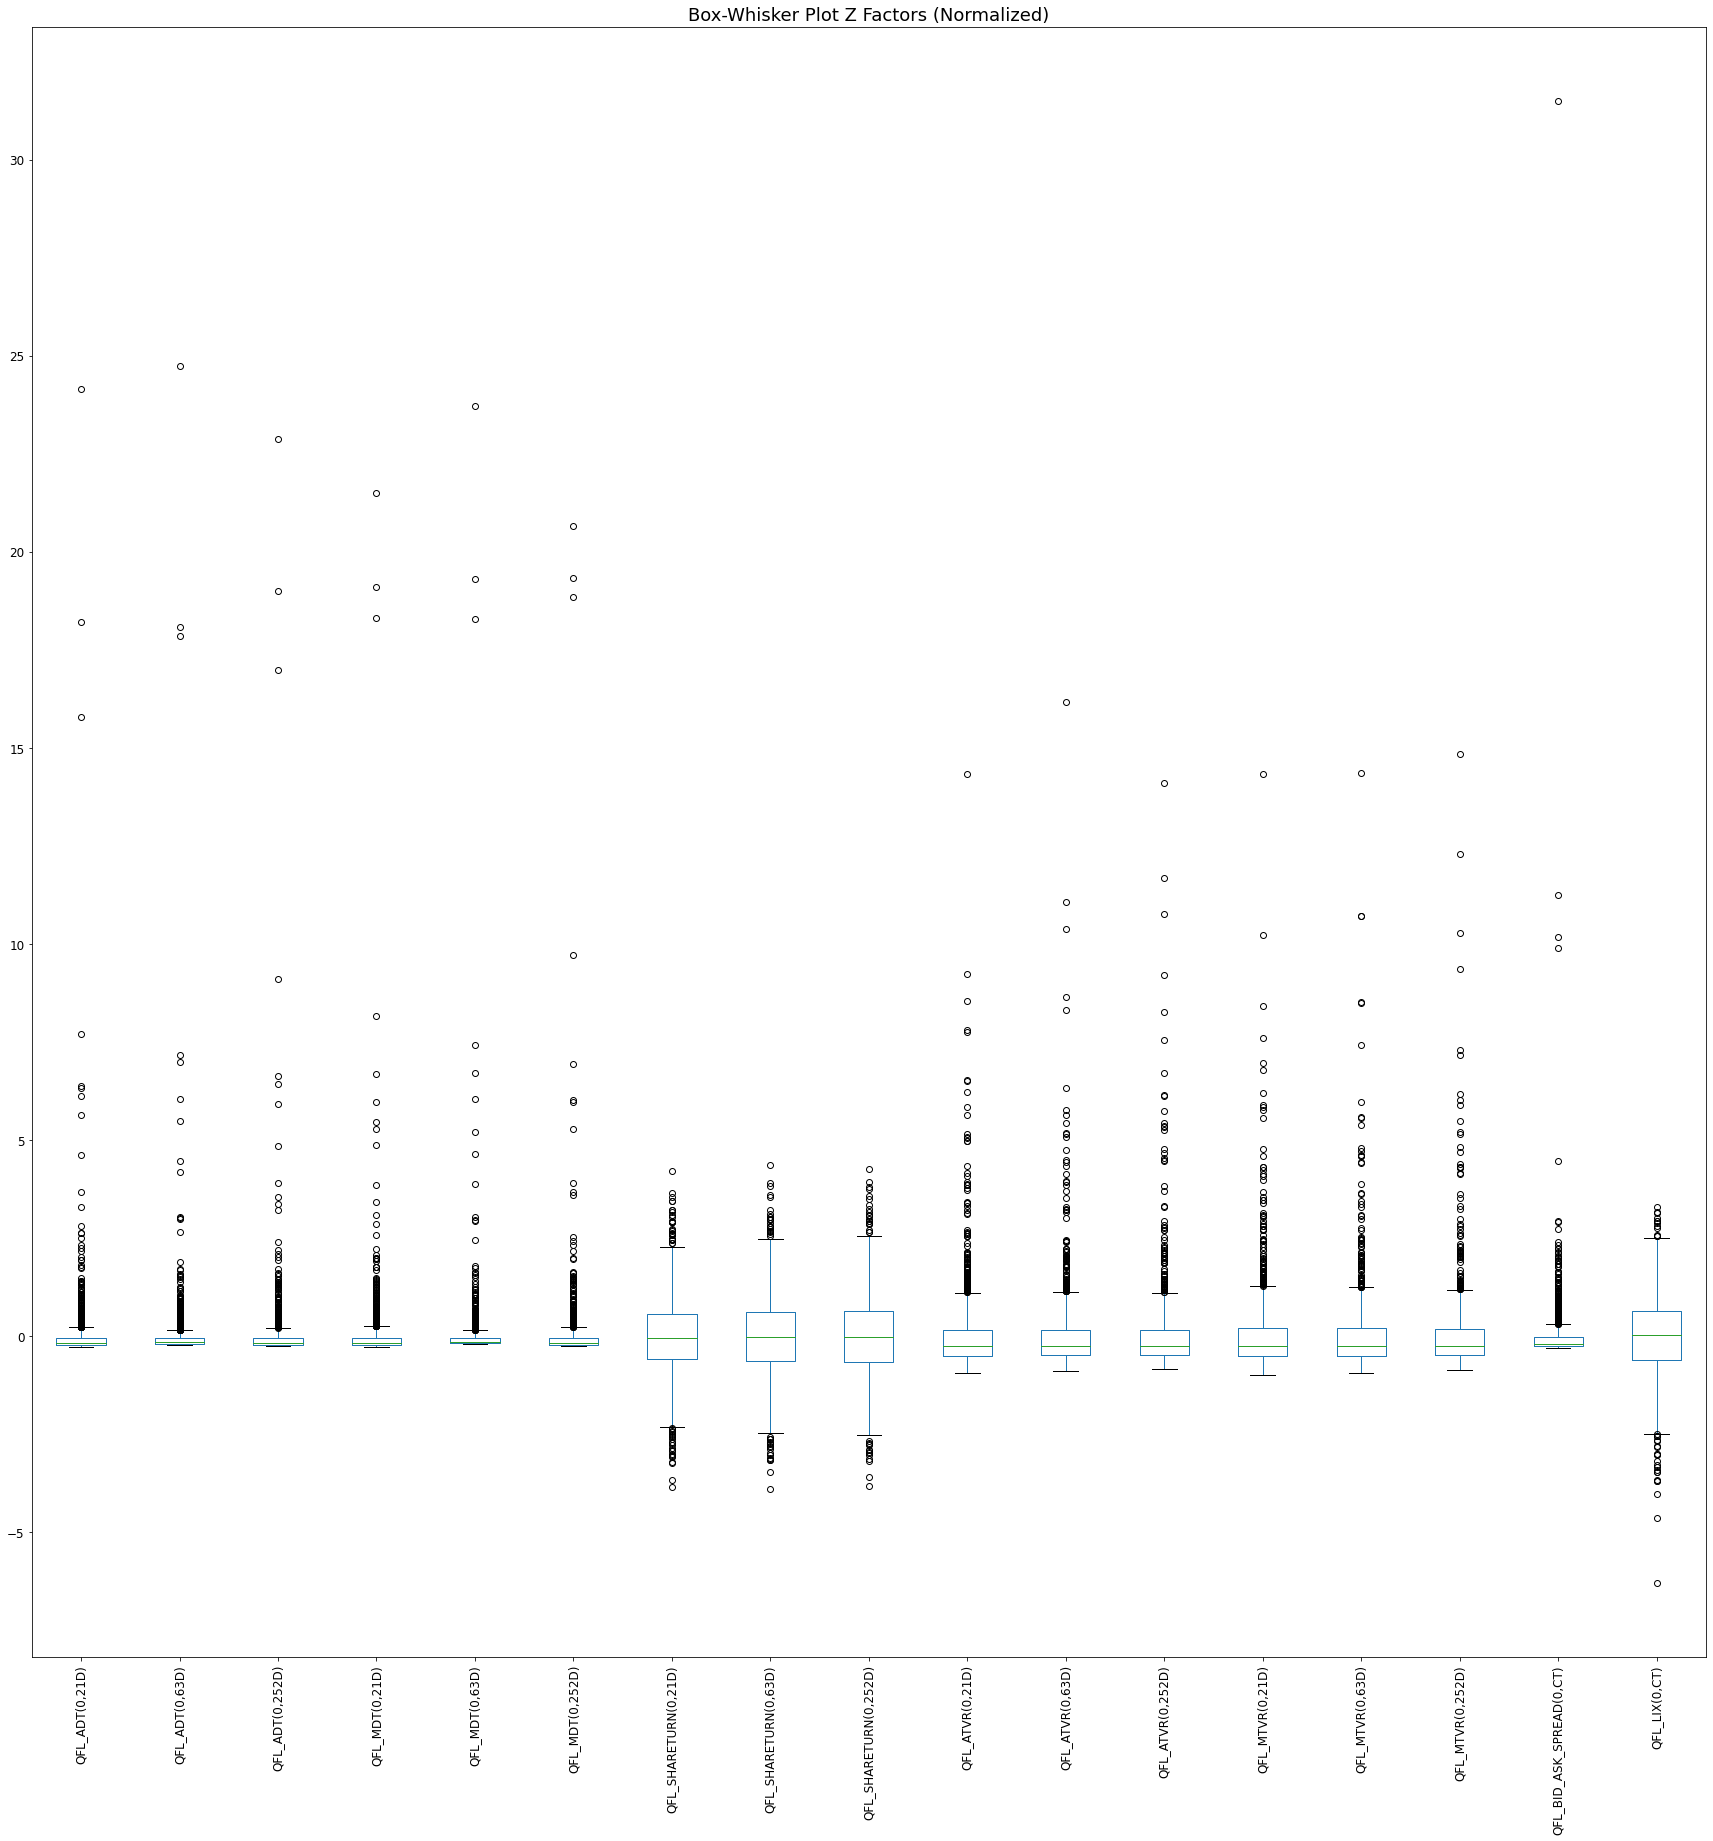

In [21]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [22]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

,"QFL_ADT(0,21D)","QFL_ADT(0,63D)","QFL_ADT(0,252D)","QFL_MDT(0,21D)","QFL_MDT(0,63D)","QFL_MDT(0,252D)","QFL_SHARETURN(0,21D)","QFL_SHARETURN(0,63D)","QFL_SHARETURN(0,252D)","QFL_ATVR(0,21D)","QFL_ATVR(0,63D)","QFL_ATVR(0,252D)","QFL_MTVR(0,21D)","QFL_MTVR(0,63D)","QFL_MTVR(0,252D)","QFL_BID_ASK_SPREAD(0,CT)","QFL_LIX(0,CT)",MFR
0,-0.265101,-0.216113,-0.253826,-0.268183,-0.212272,-0.255969,-3.851635,-3.896888,-3.812302,-0.941444,-0.880376,-0.842965,-0.992152,-0.929246,-0.862876,-0.290043,-6.298168,-1.474680
1,-0.265052,-0.216078,-0.252699,-0.267576,-0.212112,-0.255462,-3.669550,-3.475503,-3.599975,-0.934796,-0.866087,-0.836193,-0.988843,-0.916677,-0.855048,-0.290043,-4.643221,-1.326172
2,-0.262228,-0.214626,-0.251128,-0.264663,-0.210740,-0.254023,-3.224352,-3.156658,-3.181306,-0.914382,-0.851928,-0.819324,-0.966731,-0.908186,-0.836358,-0.290043,-4.014046,-1.212984
3,-0.261995,-0.214028,-0.251031,-0.264602,-0.210506,-0.253172,-3.198774,-3.145102,-3.140701,-0.913000,-0.851334,-0.817396,-0.966299,-0.907691,-0.835660,-0.290043,-3.686508,-1.188697
4,-0.261383,-0.213942,-0.250467,-0.264538,-0.210397,-0.253156,-3.081094,-3.135069,-3.035604,-0.906304,-0.850844,-0.812151,-0.966063,-0.901656,-0.834510,-0.290043,-3.685933,-1.173715


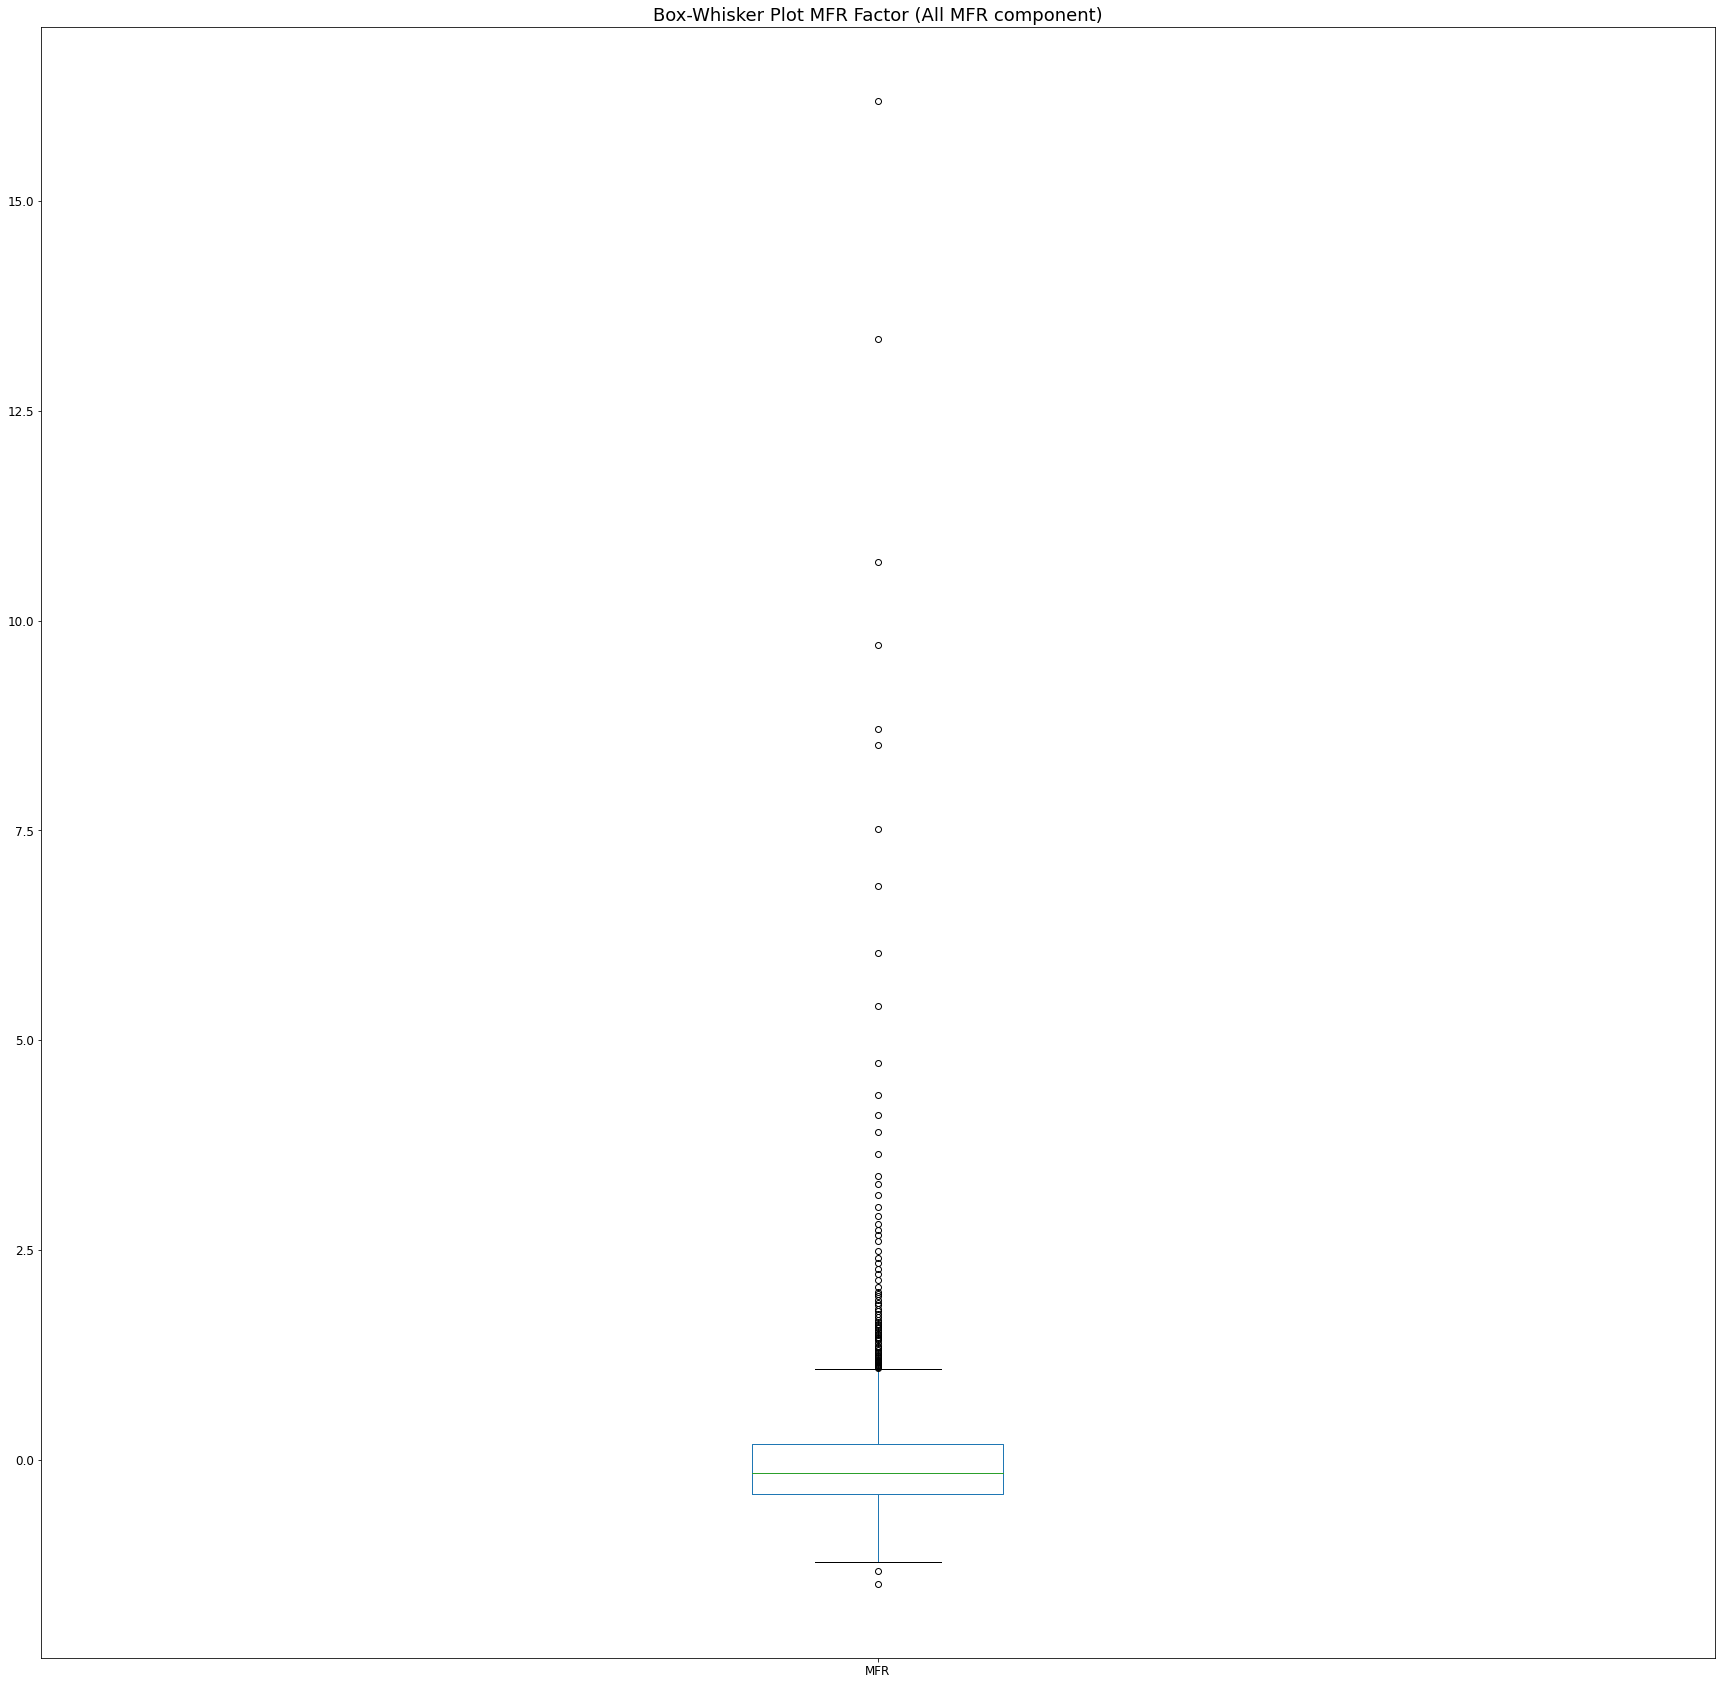

In [23]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

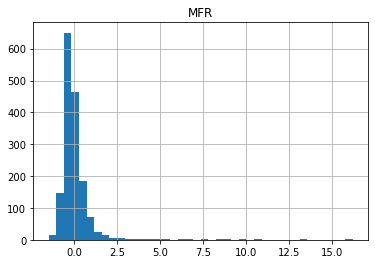

In [24]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [25]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


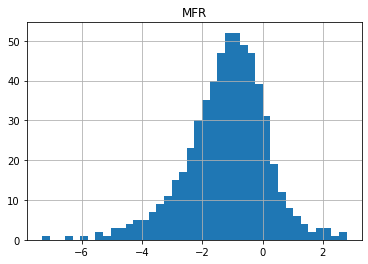

In [26]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [27]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

,"QFL_ADT(0,21D)","QFL_ADT(0,63D)","QFL_ADT(0,252D)","QFL_MDT(0,21D)","QFL_MDT(0,63D)","QFL_MDT(0,252D)","QFL_SHARETURN(0,21D)","QFL_SHARETURN(0,63D)","QFL_SHARETURN(0,252D)","QFL_ATVR(0,21D)","QFL_ATVR(0,63D)","QFL_ATVR(0,252D)","QFL_MTVR(0,21D)","QFL_MTVR(0,63D)","QFL_MTVR(0,252D)","QFL_BID_ASK_SPREAD(0,CT)","QFL_LIX(0,CT)"
0,23.192622,23.476379,23.354100,23.236867,23.411876,23.233505,-2.080314,-0.688320,0.814315,-0.519666,-0.226850,-0.110433,-0.457256,-0.296555,-0.214274,0.000168,2.270638
1,22.490814,22.581942,22.631956,22.447366,22.528303,22.558469,-2.578978,-1.374287,0.193359,-1.018332,-0.912286,-0.731080,-1.079672,-0.960232,-0.840898,0.000514,2.225281
2,23.332856,23.489744,23.242734,23.278267,23.465532,23.208959,-1.709095,-0.462338,0.887554,-0.148447,-0.000223,-0.036682,-0.210786,-0.022776,-0.100407,0.000410,2.091565
3,22.270116,22.416672,22.325524,22.144420,22.330494,22.231600,-1.907693,-0.639376,0.824581,-0.347046,-0.177347,-0.099671,-0.468972,-0.247936,-0.192943,0.000036,2.179236
4,21.791784,21.756165,21.684456,21.731528,21.648345,21.608229,-2.242193,-1.099692,0.318690,-0.681545,-0.637627,-0.605897,-0.736282,-0.723330,-0.705412,0.000670,2.077854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,16.657862,16.265798,16.186106,16.363637,16.094565,15.966623,-2.004782,-1.222668,0.068459,-0.444135,-0.760634,-0.856186,-0.744156,-0.992173,-1.041735,0.007057,2.123746
1596,16.808255,16.290759,16.208964,16.632235,16.046313,16.117831,-1.856060,-1.309878,-0.134559,-0.295412,-0.847843,-1.058823,-0.479256,-1.158397,-1.191396,0.004329,2.167341
1597,16.570085,16.173115,16.309338,16.095826,15.843097,15.933167,-2.040148,-1.274724,0.123427,-0.480031,-0.813441,-0.800931,-0.933790,-1.083645,-1.108463,0.007707,2.129179
1598,17.340355,16.890972,16.906916,17.209579,16.665111,16.849105,-1.374909,-0.794597,0.333574,0.185738,-0.332562,-0.590684,0.081743,-0.571760,-0.699294,0.010204,2.175308


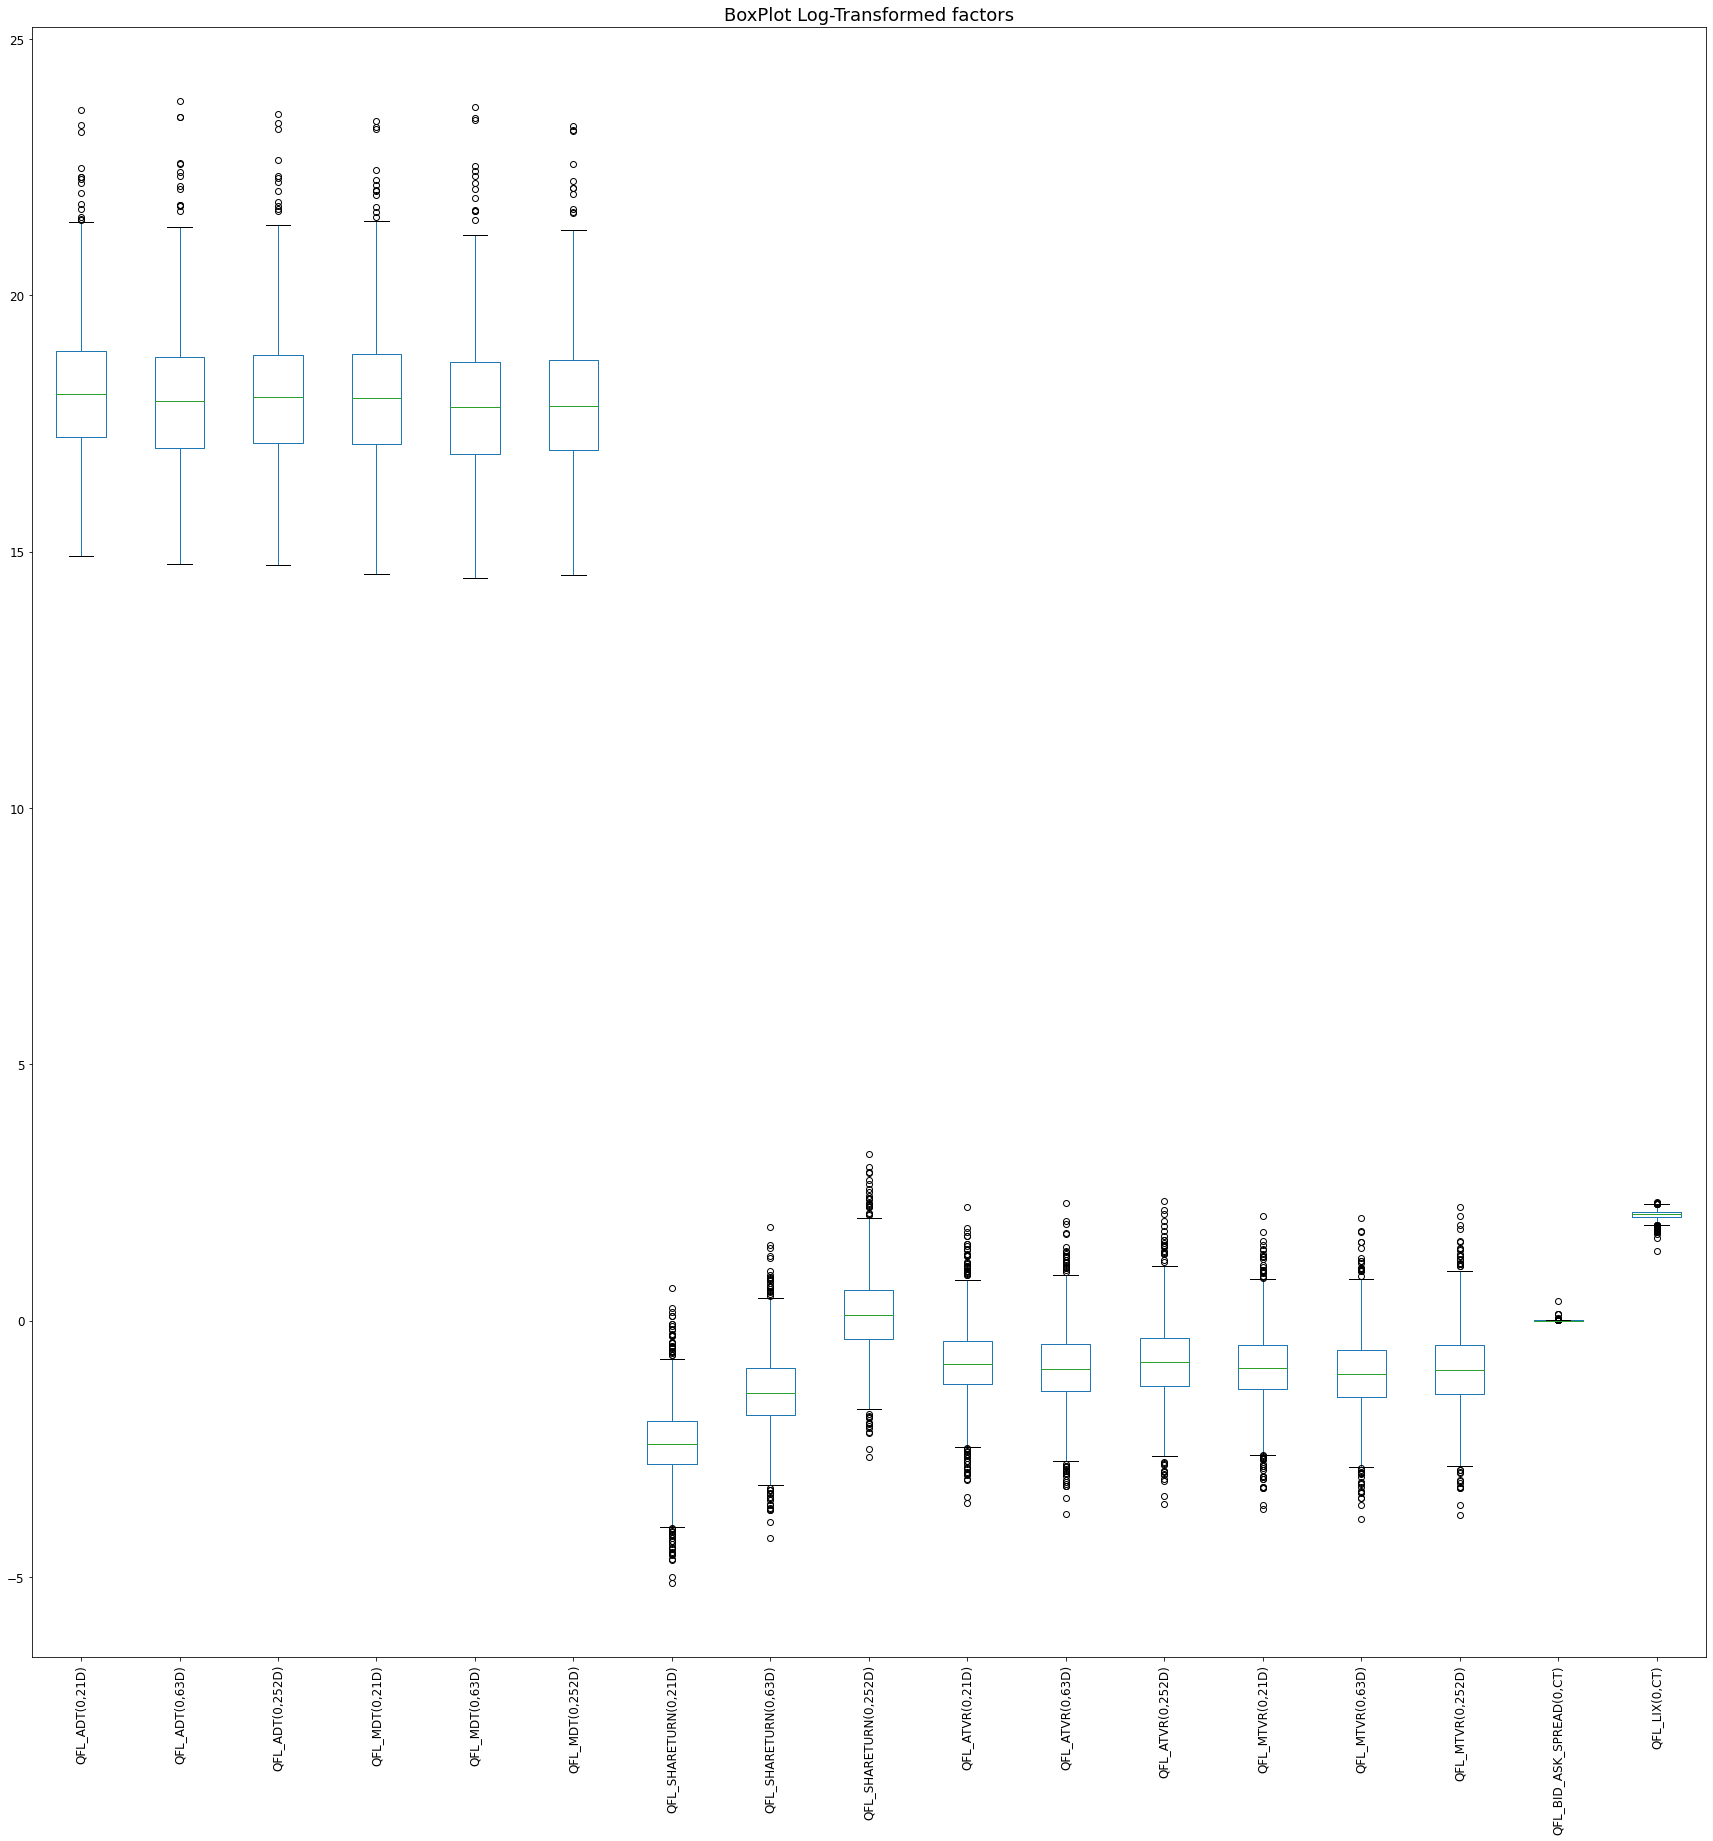

In [28]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [29]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

,"QFL_ADT(0,21D)","QFL_ADT(0,63D)","QFL_ADT(0,252D)","QFL_MDT(0,21D)","QFL_MDT(0,63D)","QFL_MDT(0,252D)","QFL_SHARETURN(0,21D)","QFL_SHARETURN(0,63D)","QFL_SHARETURN(0,252D)","QFL_ATVR(0,21D)","QFL_ATVR(0,63D)","QFL_ATVR(0,252D)","QFL_MTVR(0,21D)","QFL_MTVR(0,63D)","QFL_MTVR(0,252D)","QFL_BID_ASK_SPREAD(0,CT)","QFL_LIX(0,CT)",MFR
0,4.132816,4.367173,4.294054,4.201256,4.369239,4.278584,0.403848,0.947268,0.942361,0.403630,0.944707,0.938114,0.631780,1.002299,0.988265,-0.275800,2.444848,2.059673
1,3.558481,3.654772,3.709207,3.563016,3.672795,3.735044,-0.293686,0.011001,0.093223,-0.293700,0.008953,0.091383,-0.239662,0.099598,0.146115,-0.246467,1.899613,1.362923
2,4.247579,4.377818,4.203862,4.234723,4.411531,4.258819,0.923111,1.255708,1.042513,0.922740,1.254098,1.038731,0.976862,1.374678,1.141296,-0.255284,0.292206,2.100058
3,3.377869,3.523137,3.461035,3.318111,3.516879,3.471848,0.645311,1.014071,0.956399,0.645021,1.012289,0.952796,0.615377,1.068427,1.016933,-0.286991,1.346106,1.744389
4,2.986419,2.997057,2.941850,2.984325,2.979199,2.969908,0.177411,0.385792,0.264609,0.177261,0.383916,0.262166,0.241117,0.421820,0.328201,-0.233241,0.127397,1.199718


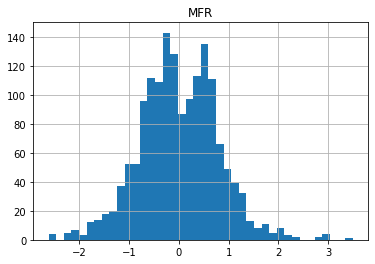

In [30]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [31]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.17
Information Coefficient (P-Value): 0.0


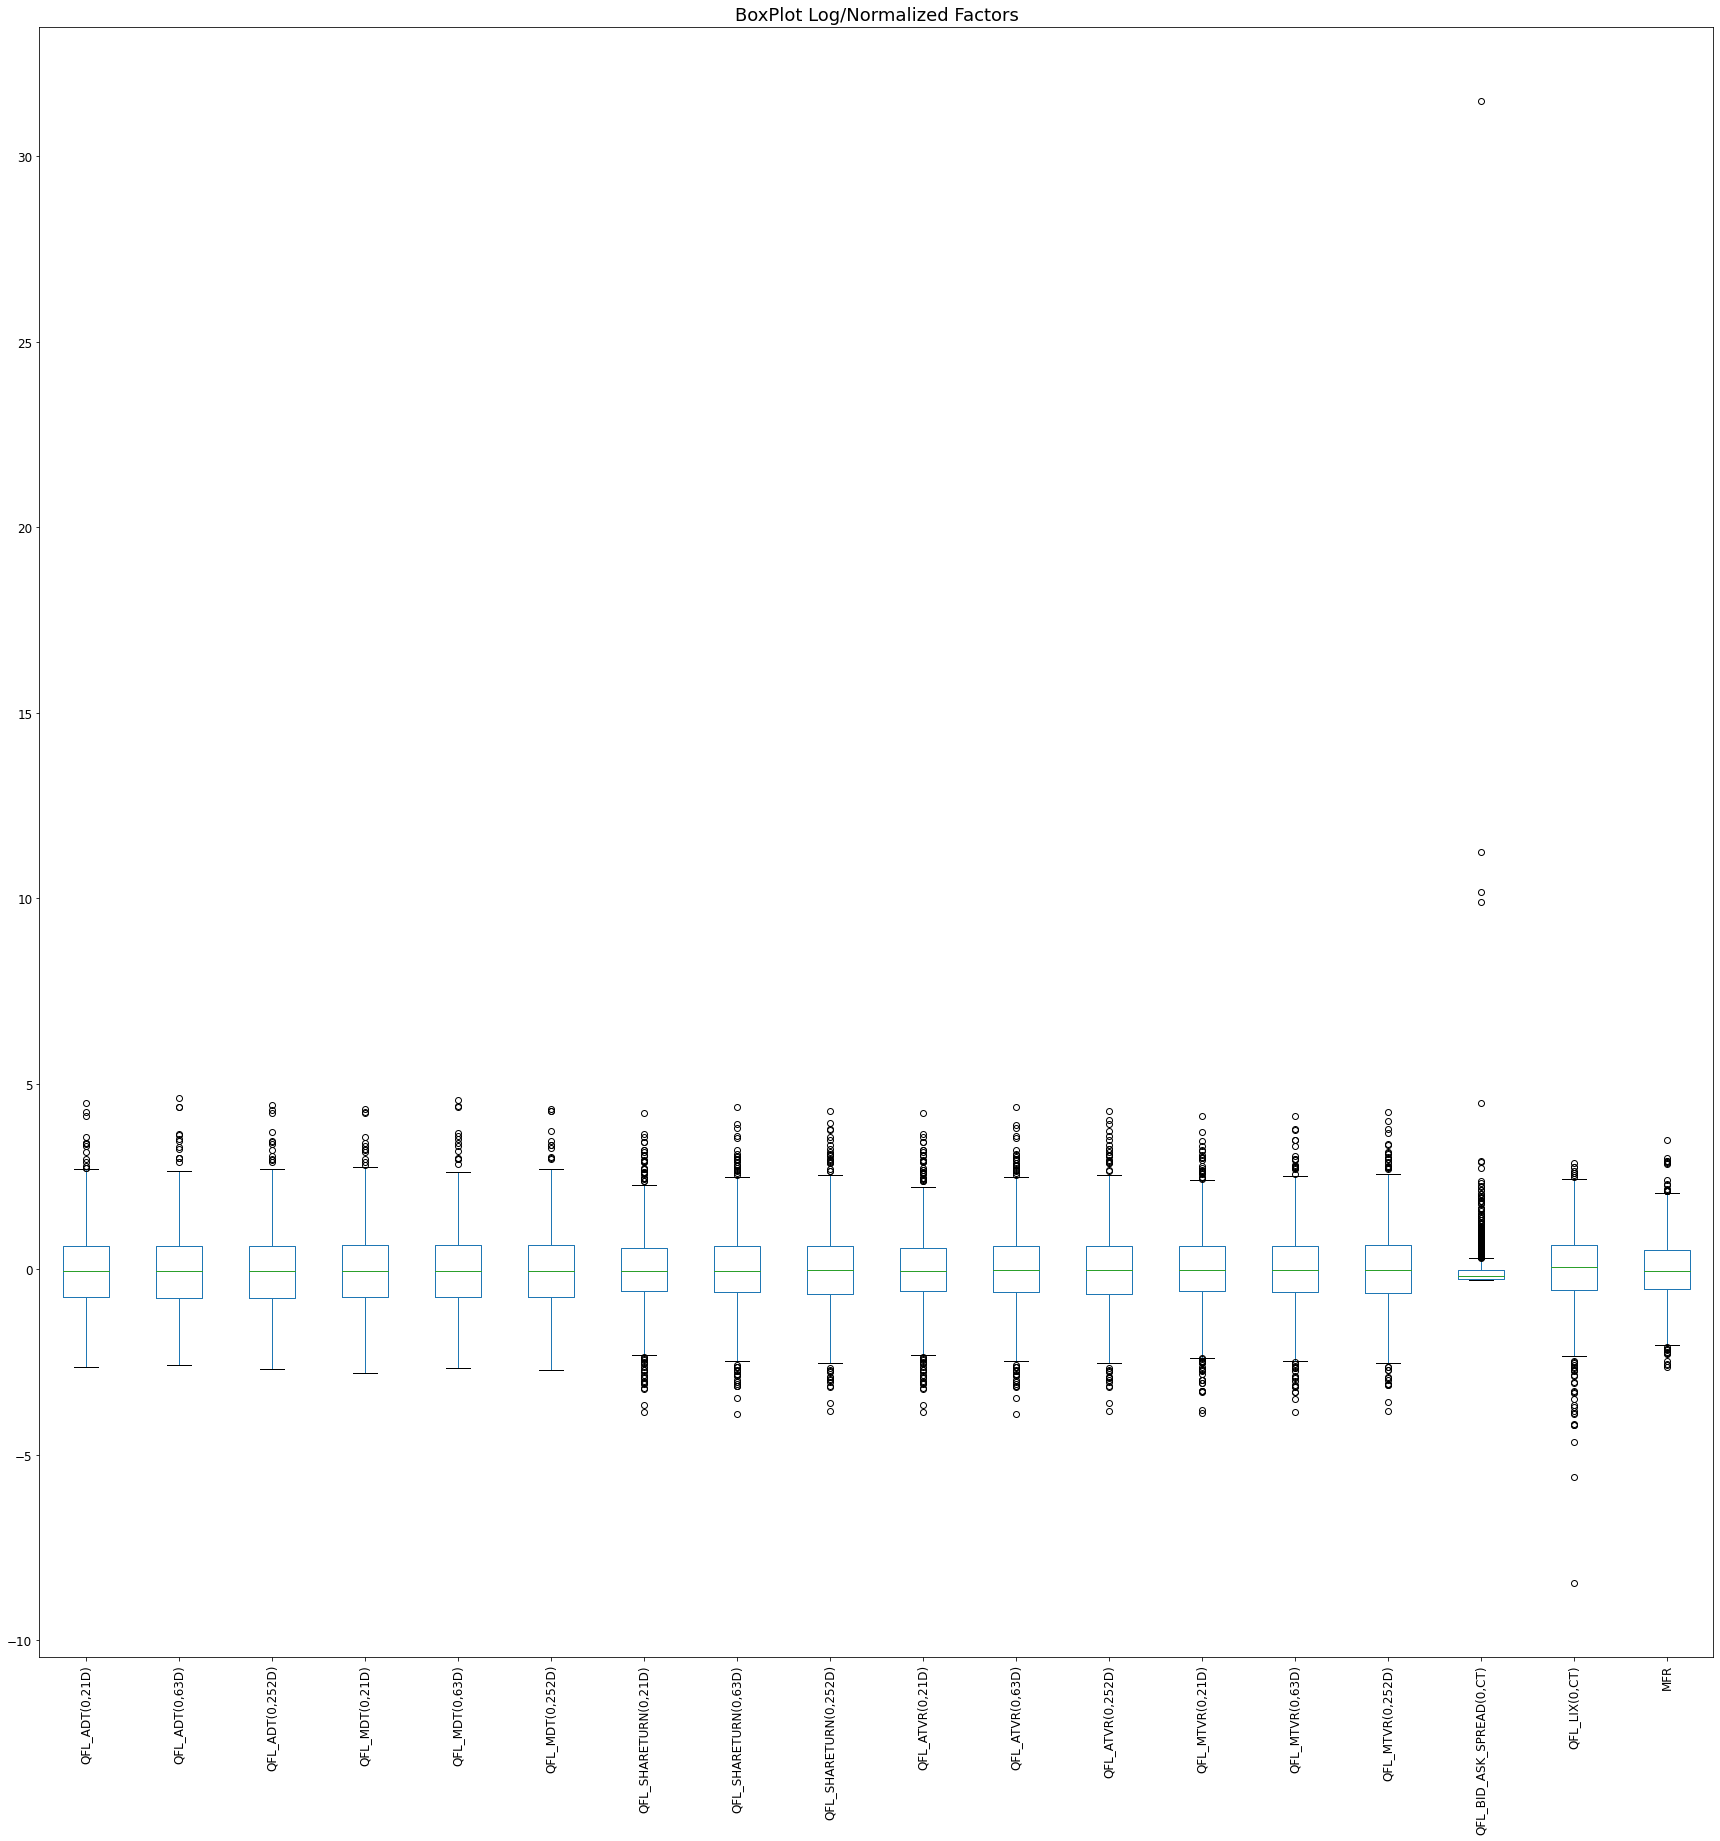

In [32]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [33]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_ADT(0,21D)","QFL_ADT(0,63D)","QFL_ADT(0,252D)","QFL_MDT(0,21D)","QFL_MDT(0,63D)","QFL_MDT(0,252D)","QFL_SHARETURN(0,21D)","QFL_SHARETURN(0,63D)","QFL_SHARETURN(0,252D)","QFL_ATVR(0,21D)","QFL_ATVR(0,63D)","QFL_ATVR(0,252D)","QFL_MTVR(0,21D)","QFL_MTVR(0,63D)","QFL_MTVR(0,252D)","QFL_BID_ASK_SPREAD(0,CT)","QFL_LIX(0,CT)",ison_screen
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,1.181484e+10,1.569141e+10,1.388534e+10,1.234932e+10,1.471122e+10,1.230787e+10,-2.080314,-0.688320,0.814315,0.594719,0.797040,0.895446,0.633018,0.743375,0.807127,0.000168,9.685576,1
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,5.856479e+09,6.415240e+09,6.744251e+09,5.607475e+09,6.080198e+09,6.266410e+09,-2.578978,-1.374287,0.193359,0.361197,0.401605,0.481389,0.339707,0.382804,0.431323,0.000514,9.256083,1
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,1.359348e+10,1.590253e+10,1.242199e+10,1.287131e+10,1.552212e+10,1.200944e+10,-1.709095,-0.462338,0.887554,0.862046,0.999777,0.963983,0.809947,0.977481,0.904469,0.000410,8.097574,1
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,4.696653e+09,5.437972e+09,4.964228e+09,4.141899e+09,4.988965e+09,4.519198e+09,-1.907693,-0.639376,0.824581,0.706773,0.837489,0.905135,0.625645,0.780410,0.824529,0.000036,8.839550,1
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,2.911063e+09,2.809199e+09,2.614808e+09,2.740834e+09,2.522067e+09,2.422895e+09,-2.242193,-1.099692,0.318690,0.505835,0.528545,0.545585,0.478891,0.485134,0.493905,0.000670,7.987313,1


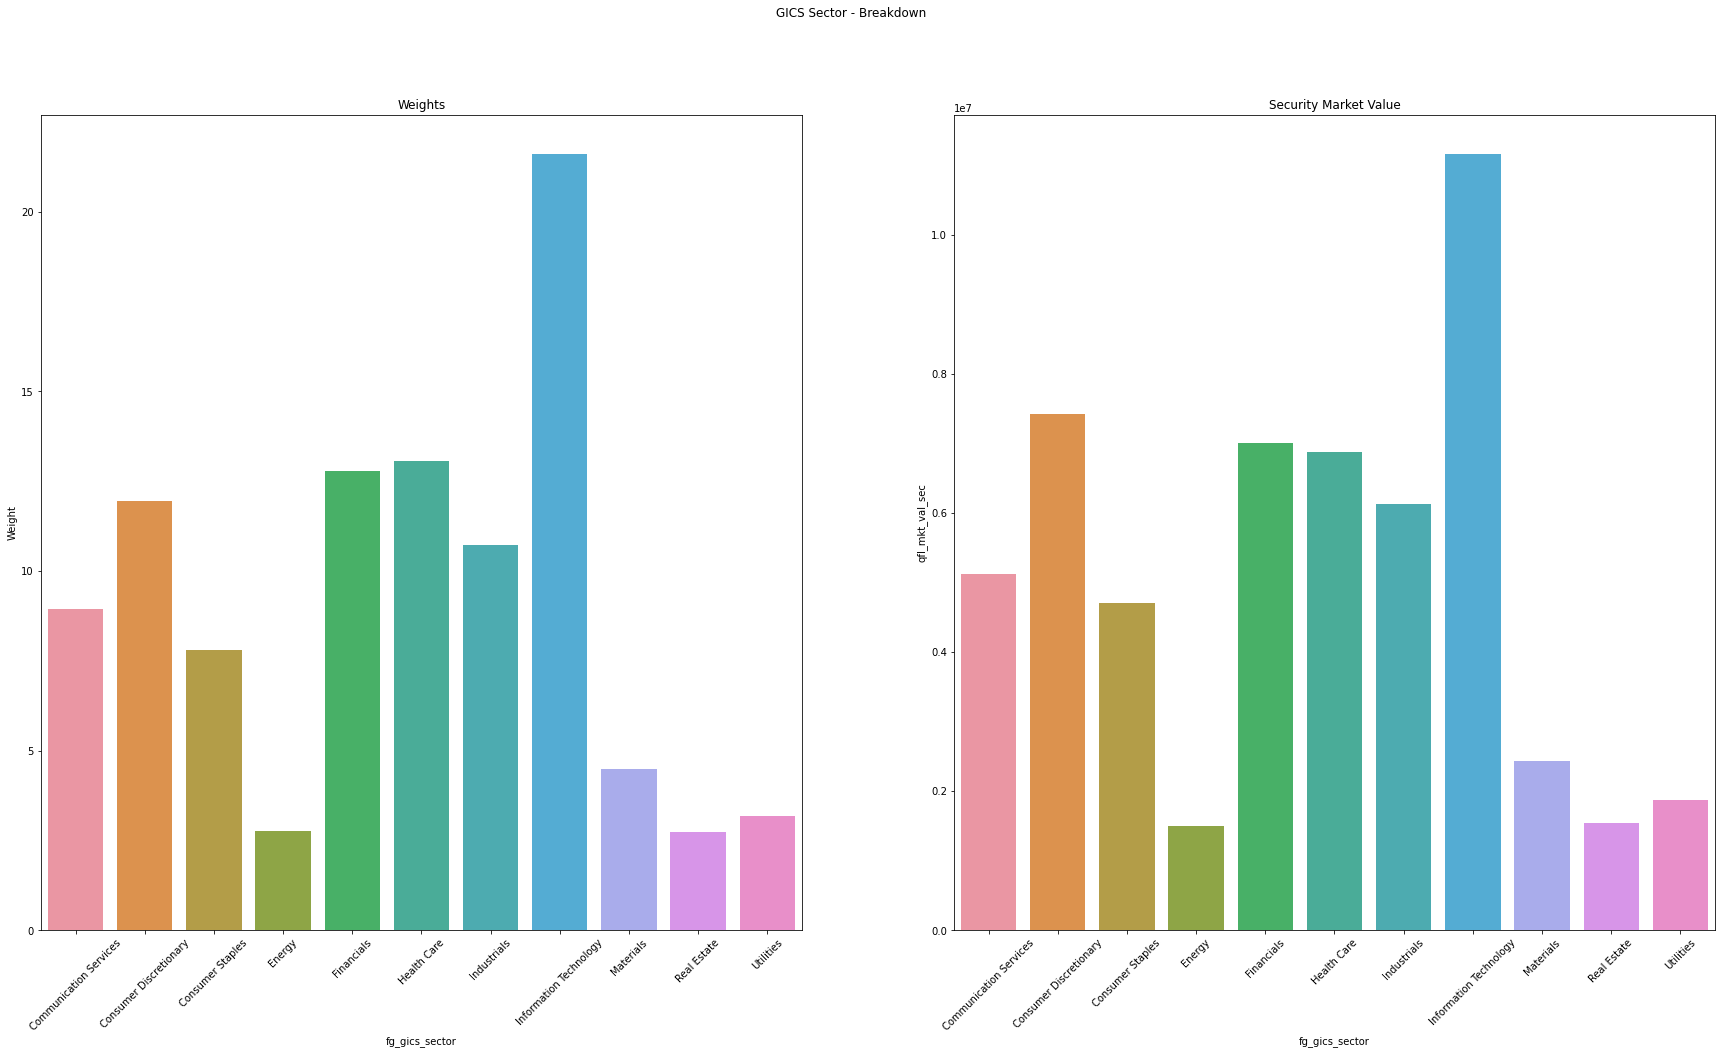

In [34]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

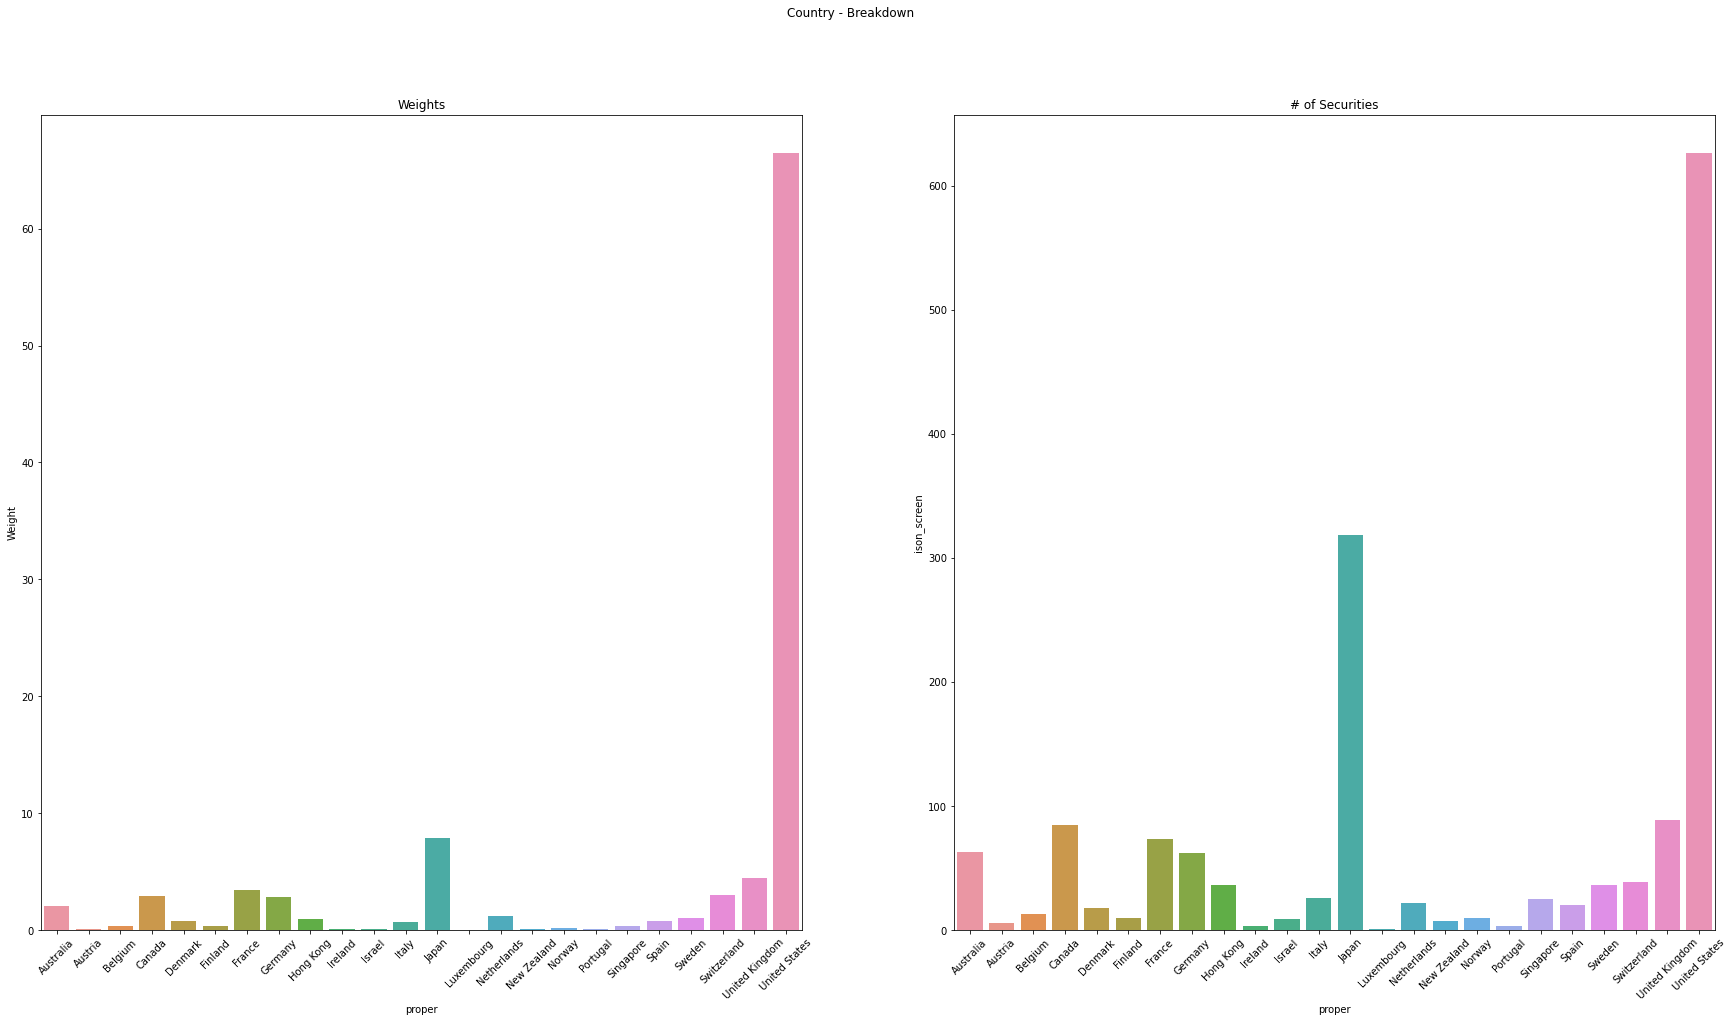

In [35]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

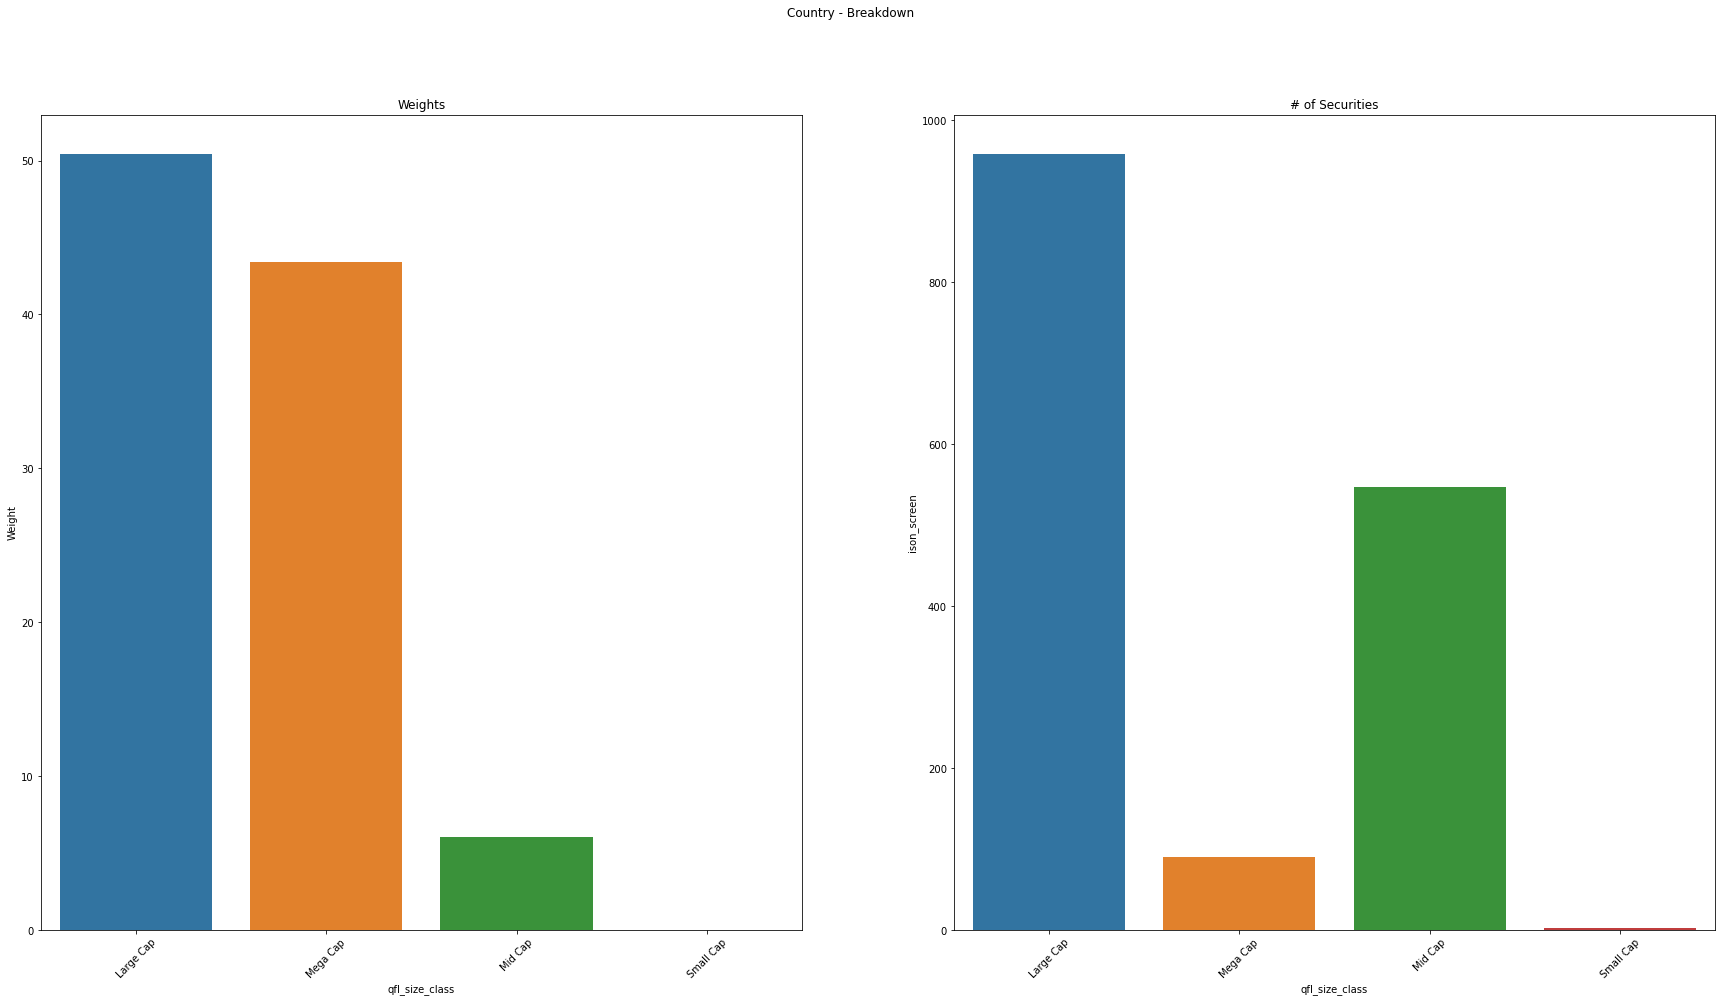

In [36]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [37]:
# Feature Selection

In [38]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [39]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-39-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [40]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41531.624808791836, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41531.624808791836, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41531.624808791836, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

Num Features: 3
Selected Features: [False False False  True False  True False  True False False False False
 False False False False False]
Feature Ranking: [ 4  2  5  1  3  1 14  1 15 13 12 11 10  9  8  7  6]


C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41556.19094773031, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.51648559462046, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.724367213158985, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(


In [41]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_MDT(0,21D)', 'QFL_MDT(0,252D)', 'QFL_SHARETURN(0,63D)'], dtype='object')

In [42]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

,"QFL_MDT(0,21D)","QFL_MDT(0,252D)","QFL_SHARETURN(0,63D)"
"QFL_MDT(0,21D)",1.000000,0.989504,0.240138
"QFL_MDT(0,252D)",0.989504,1.000000,0.217673
"QFL_SHARETURN(0,63D)",0.240138,0.217673,1.000000


In [43]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

,"QFL_MDT(0,21D)","QFL_MDT(0,252D)","QFL_SHARETURN(0,63D)"
0,1.234932e+10,1.230787e+10,-0.688320
1,5.607475e+09,6.266410e+09,-1.374287
2,1.287131e+10,1.200944e+10,-0.462338
3,4.141899e+09,4.519198e+09,-0.639376
4,2.740834e+09,2.422895e+09,-1.099692
...,...,...,...
1595,1.278313e+07,8.594413e+06,-1.222668
1596,1.672198e+07,9.997350e+06,-1.309878
1597,9.779766e+06,8.311638e+06,-1.274724
1598,2.978689e+07,2.077175e+07,-0.794597


In [44]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

,"QFL_MDT(0,21D)","QFL_MDT(0,252D)","QFL_SHARETURN(0,63D)",MFR
0,18.334654,19.367243,0.949647,12.883848
1,8.176989,9.733013,0.011028,5.973677
2,19.121111,18.891339,1.258861,13.090437
3,5.968866,6.946758,1.016618,4.644080
4,3.857938,3.603813,0.386761,2.616171


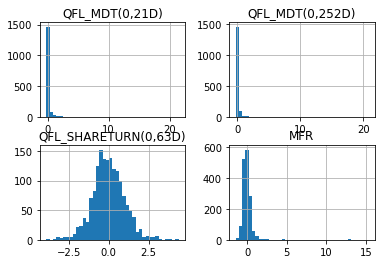

In [45]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [46]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.19
Information Coefficient (P-Value): 0.0


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [47]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.19
Information Coefficient (P-Value): 0.0


### Z-Score + Log-Transformation (All Components)

In [48]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.17
Information Coefficient (P-Value): 0.0


### Z-Score Only (All Components)

In [49]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04
